# Introduction to Data Science final project

By: Yehuda Benaish and Tal Tubul

# **imports**

In [1]:
#imports:
import bs4
from bs4 import BeautifulSoup  
import pandas as pd
import scipy as sc
import numpy as np
import requests
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import time
import pandas as pd
import re
import os.path
import csv
import ast
import math
import statistics as stat
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import matplotlib as mpl
from collections import Counter
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

UsageError: Line magic function `%matplotlib inline` not found.


# **crawling functions**

##### The next function handeling the data we get from the functions: 
```python
get_tma() 
```
```python
get_Construction_evacuation_complexes()
```
The function gets a list of addresses and returns:

   **case 1:** street's name 23-25 ==> [street's name 23, street's name 24, street's name 25]

   **case 2:** street's name 23,24 ==> [street's name 23, street's name 24]

   **case 3:** street's name 23 ==> [street's name 23]
   
   **case 4:** street's name ==> [street's name]

The function have been writed with chatGPT.

In [4]:
def fix_addresses(addresses):
    fixed_addresses = []
    for address in addresses:
        # remove number between parentheses
        address = re.sub(r'\(\d+\)', '', address)
        # split address by hyphen
        hyphen_split = address.split('-')
        for i in range(0, len(hyphen_split)):
            hyphen_split[i] = hyphen_split[i].strip()
        if len(hyphen_split) == 2:
            # check if both sides of hyphen are numbers
            if hyphen_split[0][-1].isdigit() and hyphen_split[1].isdigit() or (not hyphen_split[1].isalpha() and not any(c.isalpha() for c in hyphen_split[1])):
                start_num = int(re.sub(r'\D', '', hyphen_split[0]))
                end_num = int(re.sub(r'\D', '', hyphen_split[1]))
                # add new addresses to fixed_addresses
                for num in range(start_num, end_num + 1):
                    fixed_addresses.append(hyphen_split[0].strip('1234567890,-()') + ' ' + str(num))
            else:
                fixed_addresses.append(address)
        else:
            # check if address has numbers separated by comma
            comma_split = address.split(',')
            if len(comma_split) > 1:
                addresses = re.split('\s*,\s*', address)
                fixed_addresses.append(addresses[0])
                home = ''.join([char for char in address if char.isalpha() or char.isspace()])
                #home = address.strip('1234567890,-()')
                addresses.pop(0)
                for addr in addresses:   
                    fixed_addresses.append(f'{home} {addr}')
            else: 
                fixed_addresses.append(address)    
    return fixed_addresses

### **tma 38 projects crawlings:**
##### the next two functions get the URL of a city 
##### and return a list with all the adresses that have tma 38 project from the current URL's page


In [5]:
def get_tma(url):
# Send a GET request to the URL
    response = requests.get(url)
    # Parse the HTML content of the response using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")
    # zFind the table with the specified ID
    table = soup.find("table", {"class": "gridView"})
    # Find all the rows in the table and extract the values in the "כתובת" column
    rows = table.find_all("tr")
    addresses_p = []
    for row in rows:
        cells = row.find_all("td", attrs={"class","gv_cc"})
        if len(cells) >= 3:
            addresses_p.append(cells[1].text)
        cells = row.find_all("td", attrs={"class","gv_cc2"})
        if len(cells) >= 3:
            addresses_p.append(cells[1].text)
    addresses_p = [s.strip('\r\n\t') for s in addresses_p]
    return fix_addresses(addresses_p)

##### The next function gets city name and crawling from the website: tma-38, 
 all the tma-38 projects that are maded and projecets that are now at proccesses at the city. 
 **The function uses the next URL's:**
 ##### The next URL is to get all the tma 38 progects from type-1 that are currently in proccesses:
 ["https://www.t-m-a38.co.il/Default.aspx?gvprojects__gvac=1&gvprojects__gvff0={city}&gvprojects__gvfl0=0&gvprojects__gvpi={i}&tabid=65"](https://)
 ##### The next URL is to get all the tma 38 progects from type-2 that are currently in proccesses:
 ["https://www.t-m-a38.co.il/Default.aspx?gvprojects__gvac=1&gvprojects__gvff0={city}&gvprojects__gvfl0=0&gvprojects__gvpi={i}&tabid=118"](https://)
 ##### The next URL is to get all the tma 38 progects that have been ended thier proccesses:
 ["https://www.t-m-a38.co.il/Default.aspx?gvprojects__gvac=1&gvprojects__gvff0={city}&gvprojects__gvfl0=0&gvprojects__gvpi={i}&tabid=96"](https://)

 The function return a dict with all the adresses that have tma 38 project with the next values:

 1 ==> if the progect is during tma38 process

 2 ==> if the progect is during tma38 type 2 process 
 
 3 ==> if the progect is ended the tma38 process

 if the customer entered a wrong value of city the functions will return an empty dict.

In [6]:
def tma_df(city):
    # Initialize empty lists to store the TMA data
    unfinished_tma = []
    unfinished_tma_type2 = []
    finished_tma = []

    # Iterate over a range of 15 to retrieve TMA data from different URLs
    for i in range(15):
        # Construct the URL for unfinished TMA data and retrieve the data
        url_unfinished = f"https://www.t-m-a38.co.il/Default.aspx?gvprojects__gvac=1&gvprojects__gvff0={city}&gvprojects__gvfl0=0&gvprojects__gvpi={i}&tabid=65"
        unfinished_tma += get_tma(url_unfinished)

        # Construct the URL for unfinished TMA type 2 data and retrieve the data
        url_unfinished_type2 = f"https://www.t-m-a38.co.il/Default.aspx?gvprojects__gvac=1&gvprojects__gvff0={city}&gvprojects__gvfl0=0&gvprojects__gvpi={i}&tabid=118"
        unfinished_tma_type2 += get_tma(url_unfinished_type2)

        # Construct the URL for finished TMA data and retrieve the data
        url_finished = f"https://www.t-m-a38.co.il/Default.aspx?gvprojects__gvac=1&gvprojects__gvff0={city}&gvprojects__gvfl0=0&gvprojects__gvpi={i}&tabid=96"
        finished_tma += get_tma(url_finished)

    # Create a dictionary with TMA data where the keys are the strings and the values are the enumeration index
    string_dict = {s: i for i, strings in enumerate([unfinished_tma, unfinished_tma_type2, finished_tma], start=1) for s in strings}

    # Return the resulting dictionary
    return string_dict

### **Construction evacuation projects crawlings:**
##### The next function get's city's name and the URL of the goverment's website for Construction evacuation projects
##### and return a list with all the adresses that have been part of construction evacuation project at the current city.

In [7]:
def get_Construction_evacuation_complexes(city_name):
    # Set up the webdriver
    driver = webdriver.Chrome()
    # Navigate to the job search website
    driver.get("https://www.gov.il/apps/moch/viewlist/renew/mitchamim-rashut")
    # Wait for the paginator to load
    paginator = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "p-paginator")))
    #Find the search/filter input element and enter the city name
    time.sleep(1.2)
    search_input = driver.find_element(By.CSS_SELECTOR, "#search")
    search_input.send_keys(city_name)
    time.sleep(1)
    data = []
    # Click all "Next" buttons until there is no button left
    while True:
        next_button = paginator.find_element(By.CSS_SELECTOR, ".ui-paginator-next")
        tbody = None
        tbody = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME,"tbody")))
        try:
            time.sleep(1)
            temp = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME,"column-value")))
        except:
           print("invalid input try again...") 
           return []
        if tbody:
            some = tbody.find_elements(By.CSS_SELECTOR, "td")
            for value in some:
                data.append(value.text)
        if "ui-state-disabled" in next_button.get_attribute("class"):
            # No more next buttons, exit loop
            break
        next_button.click()  
    # Close the webdriver
    driver.quit()
    for d in range(0, len(data)):
        if ('יישוב: ' + city_name) in data[d]:
           fixed_data = data[(d+1)::9]
           break
    return  fix_addresses(fixed_data)

### **Tabu crawling:**
#### The function get the full address of an apartment and return if she have a tabu or not.
#### The function uses the next URL for crawling: https://al-harishum.moch.gov.il/
##### Due to a blocking system at the current website we coulded crawl the website...

In [ ]:
def get_tabu(city, street, number):
    strongs = None
    driver = webdriver.Chrome()
    driver.get("https://al-harishum.moch.gov.il/")
    
    # Wait for the inputs to load:
    _city = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "ctl00_ctl00_ContentPlaceHolder1_ContentPlaceHolder1_SearchPanel_TabContainer1_TabPanelAddress_txtYeshuv")))
    _number = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "ctl00_ctl00_ContentPlaceHolder1_ContentPlaceHolder1_SearchPanel_TabContainer1_TabPanelAddress_txtBait")))
    _street = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "ctl00_ctl00_ContentPlaceHolder1_ContentPlaceHolder1_SearchPanel_TabContainer1_TabPanelAddress_txtRechov")))
    
    # Enter values into the inputs:
    _city.send_keys(city)
    _number.send_keys(number)
    _street.send_keys(street)
    
    # Click the search button:
    button = driver.find_element(By.ID, "ctl00_ctl00_ContentPlaceHolder1_ContentPlaceHolder1_SearchPanel_TabContainer1_TabPanelAddress_btnAddress")
    button.click()
    
    # Check if the invalid state element exists:
    try:
        strongs = driver.find_elements(By.TAG_NAME, "strong")
        strong = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, "ctl00_ctl00_ContentPlaceHolder1_ContentPlaceHolder1_NoBotInvalidState")))
        
    except:
        pass
    
    driver.quit()
    return strongs
res = get_tabu('אשדוד', 'הר כנען 2', '2')
for r in res:
    print(r.text)

### **Yad-2 crawling:**
The function scrapes data from the Yad2 website for real estate listings. It takes the number of rooms as input and retrieves various details for each listing, such as price, address, floor, size, availability of features like air conditioning, elevators, etc.

Here's a breakdown of the steps performed in the function:

Initialize empty lists to store the extracted data.

Initialize a WebDriver using Microsoft Edge.

Navigate to the Yad2 website with the specified room parameter.

Wait for the page to load and retrieve the list of page numbers.

Iterate over each page of listings.

For each page, close any ads that may appear.

Find the item element on the page and extract the city name, street, floor, size, and price for each listing.

Click on the item to expand and reveal more details.

Extract additional details like property status, parking availability, terrace information, etc.

Check for features like sea view, sukka, and various amenities (air conditioning, bars, elevators, water heaters, accessibility, shelters, renovated status, storage, Tadiran air conditioning, furniture availability, flexibility).

Store the extracted data in the respective lists.

Write the data to a CSV file.

Clear the lists for the next page.
##### Properties: 
prices, streets, cities, floors, sizes, terraces, floors_in_building, parkings, aircondition, bars, elevators, water_headers, accessibility, shelters, renovated, storages, tadiran, furnitures, status, time_enter, sea_view, sukka.

##### The function uses the next URLs:
**Jerusalem**:https://www.yad2.co.il/realestate/forsale?topArea=100&area=7&city=3000&rooms=3-3

**Tel-aviv**: https://www.yad2.co.il/realestate/forsale?topArea=2&area=1&city=5000&rooms=3-3

**Haifa**: https://www.yad2.co.il/realestate/forsale?topArea=25&area=5&city=4000&rooms=3-3

**Rishon-lezion**: https://www.yad2.co.il/realestate/forsale?topArea=2&area=9&city=8300&rooms=3-3

**Petah-tikva**: https://www.yad2.co.il/realestate/forsale?topArea=2&area=4&city=7900&rooms=3-3

**Netanya**: https://www.yad2.co.il/realestate/forsale?topArea=19&area=17&city=7400&rooms=3-3

**Holon**: https://www.yad2.co.il/realestate/forsale?topArea=2&area=11&city=6600&rooms=3-3

**Beer-sheba**: https://www.yad2.co.il/realestate/forsale?topArea=43&area=22&city=9000&rooms=3-3

**Bnei-brakh**: https://www.yad2.co.il/realestate/forsale?topArea=2&area=78&city=6100&rooms=3-3

**Ashdod**: https://www.yad2.co.il/realestate/forsale?topArea=41&area=21&city=0070&rooms=3-3

In [8]:
def get_info(rooms):
    # Initialize empty lists to store the data
    prices = [] 
    streets = []
    cities = []
    floors = [] 
    sizes = []
    terraces = [] 
    floors_in_building = [] 
    parkings = []
    aircondition = []
    bars = [] 
    elevators = []
    water_headers = [] 
    accessibility = [] 
    shelters = [] 
    renovated = []
    storages = []
    tadiran = []
    flexiable = []
    furnitures = [] 
    status = []
    time_enter = []
    sea_view = []
    sukka = []
    to_text = []
    city = []
    # Initialize a WebDriver for web scraping
    driver = webdriver.Edge()
    # Navigate to the desired URL with the specified room parameter
    driver.get(f"https://www.yad2.co.il/realestate/forsale?topArea=100&area=7&city=3000&property=1&rooms={rooms}-{rooms}")
    # Wait for the page to load and retrieve the list of page numbers
    pages = WebDriverWait(driver, 80).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".page-num")))
    if pages:
        # Iterate over each page
        for page in range(1,int(pages.pop().text)+1):
            # Navigate to the page
            driver.get(f"https://www.yad2.co.il/realestate/forsale?topArea=100&area=7&city=3000&property=1&rooms={rooms}-{rooms}&page={page}")
            # Wait for the page to load and retrieve the updated list of page numbers
            pages = WebDriverWait(driver, 80).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".page-num"))) 
            index = 0
            while index < 39:
                try:
                    # Close the ad if present
                    ad_button = driver.find_element(By.ID, 'slot-close-button')
                    ad_button.click()
                except:
                    pass
                # Find the item element
                item = driver.find_element(By.ID, f"feed_item_{index}")
                try:
                    # Wait for the item details to load
                    time.sleep(0.8)
                    item.click()
                    waitt = WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.ID,f'accordion_wide_{index}')))
                    time.sleep(1.2)
                    # Extract additional details from the item
                    try:
                        city = item.find_element(By.CLASS_NAME, "subtitle").text
                        if city:
                            cities.append(city)
                        else: cities.append('nan')
                    except:
                        cities.append('nan')
                    street = item.find_element(By.ID, f"feed_item_{index}_title").text
                    if street:
                        streets.append(street)
                    else: streets.append('nan')
                    floor = driver.find_element(By.ID, f"data_floor_{index}").text
                    if floor:
                        floors.append(floor)
                    else: floors.append('nan')
                    size = driver.find_element(By.ID, f"data_SquareMeter_{index}").text
                    if size:
                        sizes.append(size)
                    else: sizes.append('nan')
                    price = driver.find_element(By.ID, f"feed_item_{index}_price").text
                    if price:
                        prices.append(price)
                    else: prices.append('nan')
                    waitt = WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.ID,f'accordion_wide_{index}')))
                    data_list = item.find_elements(By.TAG_NAME,'dl')
                    if data_list:
                        flag = 0
                        for d in data_list:
                            to_text.append(d.text)
                        for t in to_text:
                            if 'מצב הנכס' in t:
                                status.append(t)
                                flag = 1
                                break 
                        if flag == 0:
                            status.append('none')
                        else: flag = 0
                        for t in to_text:
                            if 'תאריך כניסה' in t:
                                time_enter.append(t)
                                flag = 1
                                break 
                        if flag == 0:
                            time_enter.append('none')
                        else: flag = 0        
                        for t in to_text:
                            if 'מרפסות' in t:
                                terraces.append(t)
                                flag = 1
                                break 
                        if flag == 0:
                            terraces.append('none')
                        else: flag = 0      
                        for t in to_text:
                            if 'חניות' in t:
                                parkings.append(t)
                                flag = 1
                                break 
                        if flag == 0:
                            parkings.append('none')
                        else: flag = 0
                        for t in to_text:
                            if 'קומות בבנין' in t:
                                floors_in_building.append(t)
                                flag = 1
                                break 
                        if flag == 0:
                            floors_in_building.append('none')
                        else: flag = 0
                        to_text.clear() 
                    else:
                        status.append('nan')
                        parkings.append('nan')
                        floors_in_building.append('nan')
                        terraces.append('nan')
                        time_enter.append('nan')
                    contect = item.find_elements(By.CLASS_NAME,"show-more-container")
                    if contect:
                        if ('הים' in contect[0].text or 'לים' in contect[0].text) and 'נוף' in contect[0].text:
                            sea_view.append(1)
                        else: sea_view.append(0)
                        if 'סוכה' in contect[0].text and 'מרפסת' in contect[0].text:
                            sukka.append(1)
                        else: sukka.append(0)
                    else: 
                        sea_view.append(0)
                        sukka.append(0)
                    elements2 = item.find_elements(By.CSS_SELECTOR, 'div.items_container > div.info_feature')
                    time.sleep(0.5)
                    if elements2:
                        for element in elements2:
                            class_name = element.get_attribute('class')
                            if class_name == 'info_feature':
                                result = 1
                            elif class_name == 'info_feature delete':
                                result = 0
                            text = element.text
                            if 'נכס בבלעדיות' in text or 'מטבח כשר' in text:
                                continue
                            if 'מיזוג' in text:
                                aircondition.append(result)
                                continue
                            elif 'סורגים' in text:
                                bars.append(result)
                                continue
                            elif 'מעלית' in text:
                                elevators.append(result)
                                continue
                            elif 'דוד שמש' in text:
                                water_headers.append(result)
                                continue
                            elif 'גישה לנכים' in text:
                                accessibility.append(result)
                                continue
                            elif 'ממ"ד' in text:
                                shelters.append(result)
                                continue
                            elif 'משופצת' in text:
                                renovated.append(result)
                                continue
                            elif 'מחסן' in text:
                                storages.append(result)
                                continue
                            elif 'מזגן תדיראן' in text:
                                tadiran.append(result)
                                continue
                            elif 'ריהוט' in text:
                                furnitures.append(result)
                                continue
                            elif 'גמיש' in text:
                                flexiable.append(result)
                                continue
                    else:
                        flexiable.append('nan')  
                        furnitures.append('nan') 
                        tadiran.append('nan') 
                        renovated.append('nan') 
                        shelters.append('nan') 
                        accessibility.append('nan') 
                        water_headers.append('nan') 
                        elevators.append('nan') 
                        bars.append('nan') 
                        aircondition.append('nan')
                        storages.append('nan') 
                    index += 1
                except:
                    pass
            print(f'{len(streets)} {len(prices)} {len(cities)} {len(sizes)} {len(floors)} {len(furnitures)}  {len(tadiran)} {len(bars)} {len(floors_in_building)} {len(parkings)} {len(sea_view)}')
            data = {
                'prices': prices,
                'streets': streets,
                'cities': cities,
                'floors': floors,
                'sizes': sizes,
                'terraces': terraces,
                'floors_in_building': floors_in_building,
                'parkings': parkings,
                'aircondition': aircondition,
                'bars': bars,
                'elevators': elevators,
                'water_headers': water_headers,
                'accessibility': accessibility,
                'shelters': shelters,
                'renovated': renovated,
                'storages': storages,
                'tadiran': tadiran,
                'furnitures': furnitures,
                'status': status,
                'time_enter': time_enter,
                'sea_view': sea_view,
                'sukka': sukka
            }
            df = pd.DataFrame(data)
            filename = 'cities_meta_data\\jerusalem_df_file_3_rooms.csv'
            #write data to the file:
            file_exists = os.path.isfile(filename)
            with open(filename, 'a', newline='') as csvfile:
                fieldnames = ['prices', 'streets', 'cities', 'floors', 'sizes', 'terraces', 'floors_in_building', 'parkings', 'aircondition', 'bars', 'elevators', 'water_headers', 'accessibility', 'shelters', 'renovated', 'storages', 'tadiran', 'furnitures', 'status', 'time_enter', 'sea_view', 'sukka']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                if not file_exists:
                    writer.writeheader()
                writer.writerow(data)
            # Clear the lists for the next page
            for l in [prices, streets, cities, floors, sizes, terraces, floors_in_building, parkings, aircondition, bars, elevators, water_headers, accessibility, shelters, renovated, storages, tadiran, furnitures, status, time_enter, sea_view, sukka]:
                l.clear()

#### The reorder_df function gets a file name of meta data with all the apartments of a city for sale in Yad-2 and performs the following tasks:
Reads the CSV file using pd.read_csv and stores the data in a DataFrame (df).

Calculates the number of apartments based on the number of entries in the 'sea_view' column. This is done by splitting the values on commas, counting the number of elements, and summing them up.

Creates a list of indexes ranging from 1 to the total number of apartments.

Creates a new DataFrame (new_df) using the 'index' list as the index column.

Iterates over each column in the original DataFrame and creates a new column in new_df by flattening the values from each row in the original DataFrame. The values are converted from strings to lists using ast.literal_eval and empty strings are removed.

Returns the reordered DataFrame (new_df).
###### The function were written with chatGPT

In [9]:
def reorder_df(file_name):
    df = pd.read_csv(file_name, encoding='hebrew')
    #finds the number of apartments at the meta data df:
    x = 0
    for row in range(0, df.shape[0]):
        x += len(df.loc[row, 'sea_view'].split(','))
    indexes = list(range(1, x+1))
    new_df = pd.DataFrame({'index':indexes}) 
    #creates a regular df:
    for column in df.columns:
        l = []
        for row in range(0, df.shape[0]):
            l += ast.literal_eval(df.loc[row, column].strip('\\n'))
        l = [i for i in l if i != '']  
        new_df[column] = l
    return new_df

##### The next function calls to reorder_df() and creates files of dataframes for each city at the cities list:

In [ ]:
def fix_df():
    cities = ['jerusalem', 'tel_aviv', 'haifa', 'rishon_lezion', 'petah_tikva', 'natanya', 'holon', 'beer_sheva', 'ashdod','bnei_brakh']
    for i in range(0, len(cities)):
        src = f'cities_meta_data\\{cities[i]}_df_file_3_rooms.csv'
        new_df = reorder_df(src)
        new_df.to_csv(f'apartments_info\\{cities[i]}_df_file_3_rooms.csv', encoding='hebrew')
        print(cities[i])
fix_df()    

### **ad-nadlan crawling:**
The get_deals function retrieves real estate deals between 2010-2020 data from a given URL. Here's how it works:

Initializes an empty dictionary data with keys representing the columns of the DataFrame.

Creates an empty DataFrame df using the data dictionary.

Sends a GET request to the provided URL using a user-agent header.

Parses the response content with BeautifulSoup.

Initializes an empty list streets to store street names.

Enters a while loop with a flag initially set to 1.

Finds all "td" elements in the soup object, which contain the deal information.

Creates a temporary DataFrame t_df using the data dictionary.

Iterates over the deal information, extracting the relevant data and appending it to the t_df.

Appends the t_df to the main DataFrame df.

Resets the index of df to ensure consecutive indices.

Checks if there is a "הבא" link for the next page. If found, extracts the URL and retrieves the next page using a new GET request. Updates the soup object for parsing.

If there is no "הבא" link, sets the flag to 0 to exit the while loop.

Returns the final DataFrame df containing all the retrieved real estate deals data.

In [11]:
def get_deals(url):
    # Create a dictionary to store the column names and empty lists as values
    data = {'city':[],'street':[],'rooms':[],'size':[],'floor':[],'date_builded':[],
            '2010':[],'2011':[],'2012':[],'2013':[],'2014':[],'2015':[],'2016':[],
            '2017':[], '2018':[], '2019':[], '2020':[], '2021':[], '2022':[],'2023':[]
    }
    df = pd.DataFrame(data)
    # Set up user agent header for the GET request       
    user_agent= {'User-agent': 'Mozilla/5.0'}
    # Send a GET request to the provided URL
    response = requests.get(url, headers=user_agent)
    # Parse the response content with BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")
    streets = []
    flag = 1
    # Loop to iterate through all pages of the deals
    while(flag):
        # Find all "td" elements in the soup object
        vals = soup.find_all("td")
        # Create a temporary DataFrame to store the data for this iteration
        t_df = pd.DataFrame(data)
        row_index = 1
        # Iterate through the deal information
        for i, street in enumerate(vals[2::9]):
            # Extract the date and year from the deal information
            date = vals[(i * 9 + 0)].text
            year = date[-4:]
            # Append the street name to the list if it's isn't empty
            if street.text == '':
                continue
            else:
                streets.append(street.text)
                # Create a row DataFrame with the deal information
                row =pd.DataFrame({
                    'city':vals[i * 9 + 1].text,'street': vals[i * 9 + 2].text,
                    'rooms':vals[i * 9 + 3].text,'size':vals[i * 9 + 4].text,
                    'floor':vals[i * 9 + 5].text,'date_builded':vals[i * 9 + 8].text,
                    '2010':'none','2011':'none','2012':'none','2013':'none','2014':'none',
                    '2015':'none','2016':'none','2017':'none', '2018':'none', '2019':'none', 
                    '2020':'none','2021':'none', '2022':'none','2023':'none'}, index=[row_index])    
                # Set the price for the corresponding year
                row[year] = vals[i * 9 + 6].text #to get the full price enter : vals[i * 9 + 6].text
                # Concatenate the row DataFrame with the temporary DataFrame
                t_df = pd.concat([row,t_df.loc[:]], ignore_index=True)
                row_index += 1
        # Concatenate the temporary DataFrame with the main DataFrame
        df = pd.concat([df, t_df])
        # Reset the index of the main DataFrame to ensure consecutive indices
        df = df.reset_index(drop=True)
        # Check if there is a link for the next page
        link = soup.find_all('a',attrs={'class','page-link text-nowrap px-3 py-2 rounded-pill'}).pop()
        if 'הבא' in link.text:
            next_page = 'https://www.ad.co.il' + soup.find_all('a',attrs={'class','page-link text-nowrap px-3 py-2 rounded-pill'}).pop()['href']
            response = requests.get(next_page,headers=user_agent)
            soup = BeautifulSoup(response.content, "html.parser")
        # Set the flag to 0 to exit the while loop
        else: flag = 0 
    # Return the final DataFrame containing all the retrieved real estate deals data      
    return df

##### The create_deals_files function collects real estate deal data from multiple URLs, processes the data, and saves it to separate CSV files for each city
##### links for last deals in real estate:
**Jerusalem**: https://www.ad.co.il/nadlanprice?rooms=3,3&city=jerusalem&year=2010,2023&area=jerusalem-maale-adummim&pageindex=1

**Tel-aviv**: https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=tel-aviv-area&city=tel-aviv&pageindex=1

**Haifa**: https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=haifa-hof-hacarmel&city=haifa&pageindex=1

**Rishon-lezion**: https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=rishon-lezion-area&city=rishon-lezion&pageindex=1

**Petah-tikva**: https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=petah-tikva-area&city=petah-tikva,givat-hashlosha&pageindex=1

**Netanya**: https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=netanya&area=netanya-area&pageindex=1

**Holon**:https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=netanya&area=netanya-area&pageindex=1

**Beer-sheba**:  https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=beersheba&area=beer-sheva-area&pageindex=1

**Bnei-brakh**:https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=bnei-brakh&area=ramat-gan-givatayim&pageindex=1

**Ashdod**:https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=ashdod-ashkelon&city=ashdod&pageindex=1



In [12]:
def create_deals_files():
    urls = ['https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=bnei-brakh&area=ramat-gan-givatayim&orderby=4'
            'https://www.ad.co.il/nadlanprice?rooms=3,3&city=jerusalem&year=2010,2023&area=jerusalem-maale-adummim&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=tel-aviv-area&city=tel-aviv&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=haifa-hof-hacarmel&city=haifa&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=rishon-lezion-area&city=rishon-lezion&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=petah-tikva-area&city=petah-tikva,givat-hashlosha&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=netanya&area=netanya-area&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=holon&area=holon-area&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&city=beer-sheva&area=beer-sheva-area&orderby=4',
            'https://www.ad.co.il/nadlanprice?rooms=3,3&year=2010,2023&area=ashdod-ashkelon&city=ashdod&orderby=4',
        ]    
    cities = ['jerusalem', 'tel_aviv', 'haifa', 'rishon_lezion', 'petah_tikva', 'natanya', 'holon', 'beer_sheva', 'ashdod','bnei_brakh']
    for i, url in enumerate(urls):
        result = get_deals(url)
        result.drop_duplicates(inplace=True, ignore_index=True)
        print(cities[i])
        result.to_csv(f'deals_by_price\\{cities[i]}_3_rooms.csv', encoding='hebrew')
create_deals_files()

### **gov-nadlan crawling:**
##### The get_last_deals() function uses Selenium and Chrome WebDriver to scrape the latest real estate deal data from the "www.nadlan.gov.il" website for a specific city. The function gets the city's name and time count for scrolling down and then crawls all the data about all the deals that have been made in that city from 2021 to 2023:

In [13]:
def get_last_deals(city, h_city, scroll_time):
    temp_l=[]
    # Initialize the Chrome WebDriver
    driver = webdriver.Chrome()
    driver.get(f"https://www.nadlan.gov.il/?search={h_city}")
    time.sleep(30)
    # Wait for the table to load
    wait = WebDriverWait(driver, 30)
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, ".rbutton")))
    # Get the initial scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    # Scroll and load more data for the specified time
    start_time = time.time()
    while  scroll_time !=0:
        time.sleep(1)
        # Scroll down to the bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        scroll_time-=1
    # Extract the data from the table
    items = driver.find_elements(By.CSS_SELECTOR, ".rbutton")
    for item in items:
        apartment_data_list = item.find_elements(By.TAG_NAME, "div")
        for data in apartment_data_list:
                temp_l.append(data.text)
    driver.quit()
    date_obj = r'^\d{2}\.\d{2}\.\d{4}'
    # Initialize the lists to store the extracted data
    sale_day_l = [] 
    adress_l= []
    size_l = [] 
    floor_l = []  
    price_l = []
    city_l=[]
        
    index=0 
    while(index<len(temp_l)):
        if re.match(date_obj,temp_l[index])!=None and re.match(date_obj,temp_l[index+1])==None:
            sale_day_l.append(temp_l[index])
            adress_l.append(temp_l[index+2])
            floor_l.append(temp_l[index+10])
            size_l.append(temp_l[index+12])
            price_l.append(temp_l[index+14])
            city_l.append(h_city)
            index+=18
        else:
            index+=1
    # Create DataFrame from the extracted data
    dic = {
        "sale_day": sale_day_l,
        "city":city_l,
        "address":adress_l,
        "floor": floor_l,
        "size": size_l,
        "price": price_l
        }
    df = pd.DataFrame(dic)
    df.to_csv(f"last_deals_by_price\\{city}_Deals_dataFrame.csv", encoding='hebrew')

The create_files_of_last_deals() function runs in loop for each city in the cities list and calls to get last deals() function.

In [14]:
def create_files_of_last_deals():
    citys_dict={"tel_aviv":["תל אביב", 3800],"jerusalem":["ירושלים", 3600],'beer_sheva': ["באר שבע", 3600], 'haifa':["חיפה", 3200],
                'rishon-lezion': ["ראשון לציון", 1800], 'bnei_brakh':["בני ברק", 900], 'ashdod':["אשדוד", 900], 'petah_tikva':["פתח תקווה", 900],
                  'holon':["חולון", 1600], 'natanya':["נתניה", 900]
                }
    for key, value in citys_dict.items():
        get_last_deals(key, value[0], value[1])

## **creating final files**
#### The next function takes care of all the data frames that we crawled and creates files from them, one data frame per city from the cities list.

##### The remove_characters() function takes a list, dictionary, or a DataFrame as input. 
It removes unwanted characters from the strings in the input data, such as '-', "'", '/', '"', '.', 'יי', and 'וו'. 

It also removes specific words like 'מפה', 'שד', and 'שדרות'. 

The function sorts the words in reverse order and removes leading and trailing spaces from each word. 

For lists, it returns a sorted list of processed strings. 

For dictionaries, it returns a sorted dictionary with processed strings as keys and their corresponding values. 

For a DataFrames, it updates the 'streets' column with the processed strings and returns the modified DataFrame.

In [2]:
def remove_characters(strings):
    # If input is a list
    if type(strings) == list:
        result = []
        for string in strings:
            # Replace unwanted characters, Split string into words and Remove specific words
            cleaned_string = string.replace('-', ' ').replace("'", '').replace('/', '').replace('"', '').replace('.', '').replace('יי', 'י').replace('וו', 'ו')
            cleaned_string = cleaned_string.split(" ")
            if 'מפה' in cleaned_string:
                cleaned_string.remove('מפה')
            if 'שד' in cleaned_string:
                cleaned_string.remove('שד')
            if 'שדרות' in cleaned_string:
                cleaned_string.remove('שדרות')
            # Sort the words in reverse order
            cleaned_string.sort(reverse=True)
            # Remove leading and trailing spaces from each word
            cleaned_string = [k.strip() for k in cleaned_string]
            # Join the words back into a string and Append the processed string to the result list
            string_template = ' '.join(cleaned_string)
            result.append(string_template.strip())
            # Sort the result list
            result.sort()
    # If input is a dictionary
    elif type(strings) == dict:
        result = {}
        for key, value in strings.items():
            # Replace unwanted characters, Split string into words and Remove specific words
            cleaned_string = key.replace('-', ' ').replace("'", '').replace('/', ' ').replace('"', '').replace('.', ' ').replace('יי', 'י').replace('וו', 'ו')
            cleaned_string = cleaned_string.split(" ")
            if 'מפה' in cleaned_string:
                cleaned_string.remove('מפה')
            if 'שד' in cleaned_string:
                cleaned_string.remove('שד')
            if 'שדרות' in cleaned_string:
                cleaned_string.remove('שדרות')
            # Sort the words in reverse order
            cleaned_string.sort(reverse=True)
            # Remove leading and trailing spaces from each word
            cleaned_string = [k.strip() for k in cleaned_string]
            # Join the words back into a string
            string_template = ' '.join(cleaned_string)
            # Add the processed string to the result dictionary
            result[string_template.strip()] = value
        # Sort the result dictionary by keys
        result = dict(sorted(result.items()))
    # If input is a pandas DataFrame
    elif type(strings) == type(pd.DataFrame()):
        result = strings
        for index, street in enumerate(result['streets']):
            # Replace unwanted characters, Split string into words and Remove specific words
            cleaned_string = street.replace('-', ' ').replace("'", '').replace('/', ' ').replace('"', '').replace('.', ' ').replace('יי', 'י').replace('וו', 'ו')
            cleaned_string = cleaned_string.split(" ")
            # Remove leading and trailing spaces from each word
            cleaned_string = [k.strip() for k in cleaned_string]
            if 'מפה' in cleaned_string:
                cleaned_string.remove('מפה')
            if 'שד' in cleaned_string:
                cleaned_string.remove('שד')
            if 'שדרות' in cleaned_string:
                cleaned_string.remove('שדרות')
            # Sort the words in reverse order
            cleaned_string.sort(reverse=True)
            # Join the words back into a string
            string_template = ' '.join(cleaned_string)
            # Update the 'streets' column with the processed string
            result.loc[index, 'streets'] = string_template.strip()    
    return result

#### The merge_deals_df(city, h_city) function is designed to merge existing deals data with new deals data. It takes two parameters: city, which represents the city name, and h_city, which represents the Hebrew city name. The function performs the following steps:

It reads the existing deals DataFrame (deals_df) from a CSV file and the new deals DataFrame (new_deals_df) from another CSV file.

The function renames the 'street' column in deals_df to 'streets' and renames the 'adress' column in new_deals_df to 'streets' for consistency.

If the 'Unnamed: 0' column exists in either DataFrame, it is dropped to remove unnecessary data.

The function applies the remove_characters() function to clean the 'streets' column in both DataFrames and drops rows with missing values in the 'streets' column.

Duplicate rows in new_deals_df based on specific columns (sale_day, city, streets, floor, size, price) are dropped to avoid redundancy.

The function iterates over the rows in new_deals_df and performs the following actions:
    
    If the 'streets' value is empty, the iteration continues to the next row.

    Otherwise, the year is extracted from the 'sale_day' column, and if it is '2025', it is changed to '2023' for consistency.

    Missing values or empty spaces in the 'size' column are replaced with 0.

    A new row is created with the necessary data to be appended to deals_df.

    The price from new_deals_df is assigned to the corresponding year column in the new row.

    The new row is appended to deals_df.

Finally, deals_df is sorted by the 'streets' column and the index is reset.

The function then returns the merged and updated deals_df DataFrame, which contains both the existing deals data and the new deals data.

In [3]:
def merge_deals_df(city, h_city):
    # Read the existing deals DataFrame and the new deals DataFrame
    deals_df = pd.read_csv(f'deals_by_price\\{city}_3_rooms.csv', encoding="hebrew")
    new_deals_df = pd.read_csv(f'last_deals_by_price\\{city}_Deals_dataFrame.csv', encoding="hebrew")
    # Rename the columns for consistency
    deals_df.rename(columns={'street': 'streets'}, inplace=True)
    new_deals_df.rename(columns={'adress': 'streets'}, inplace=True)
    # Drop the 'Unnamed: 0' column if it exists and apply the remove_characters function to clean the 'streets' column and drop rows with missing values
    for df in [deals_df, new_deals_df]:
        if 'Unnamed: 0' in df.columns:
            df.drop(['Unnamed: 0'], axis=1, inplace=True)
        df = remove_characters(df)
        df.dropna(subset=['streets'], inplace=True)
    # Drop duplicate rows based on specific columns in the new deals DataFrame
    new_deals_df.drop_duplicates(subset=['sale_day', 'city', 'streets', 'floor', 'size', 'price'] , inplace=True, ignore_index=True)
    # Iterate over the rows in the new deals DataFrame
    for index in range(0, new_deals_df.shape[0]):
        if new_deals_df.loc[index, 'streets'] == "":
            continue
        else:
            # Extract the year from the sale_day column
            date = new_deals_df.loc[index, 'sale_day']
            date = date[-4:]
            if date == '2025':
                date = '2023'
            # Replace missing values in the size column with 0
            if pd.isna(new_deals_df.loc[index, 'size']) or new_deals_df.loc[index, 'size'] == ' ':
                new_deals_df.loc[index, 'size'] = 0
            # Create a new row to append to the existing deals DataFrame
            row = {'city':h_city,	'streets': new_deals_df.loc[index, 'streets'], 'rooms':3, 'size':round(float(new_deals_df.loc[index, 'size'])) + 600,
                    "floor":100, "date_builded":0, '2010': 'none', '2011': 'none', '2012': 'none', '2013': 'none', '2014': 'none', '2015': 'none',
                     '2016': 'none', '2017': 'none','2018': 'none',	'2019': 'none',	'2020': 'none',	'2021': 'none',	'2022': 'none',	'2023': 'none'
                    }
            # Replace the value for the specific year column with the price from the new deals DataFrame
            row[date] = str(new_deals_df.loc[index, 'price']).replace(",", "")
            row[date] = int(row[date])
            # Append the new row to the existing deals DataFrame
            deals_df.loc[len(deals_df.index)] = row
    # Sort the deals DataFrame by streets column and reset the index
    deals_df.sort_values(by=['streets'], inplace=True)
    deals_df.reset_index(drop=True, inplace=True)      

    return deals_df                

##### The clean_deals_df() function cleans and processes the merged deals DataFrame for different cities. It performs the following steps:

Initializes dictionaries and variables for data storage and tracking.

Iterates over each city and its corresponding Hebrew city name.

Merges and retrieves the DataFrame for the current city.

Drops unnecessary columns and rows with missing values.

Removes duplicate rows based on specific columns.

Creates a new DataFrame to store the cleaned data.

Processes rows with the same street name, updating values and calculating averages.

Saves the cleaned DataFrame to a CSV file for each city.

In [ ]:
def clean_deals_df():
    # A dictionary mapping city names to their Hebrew counterparts.
    cities = {'jerusalem':'ירושלים','tel_aviv':'תל אביב', 'haifa':'חיפה', 'rishon_lezion':'ראשון לציון', 'petah_tikva':'פתח תקווה',
               'natanya':'נתניה', 'holon':'חולון', 'beer_sheva':'באר שבע', 'ashdod':'אשדוד','bnei_brakh':'בני ברק'}
    # A dictionary to store the cleaned data
    data = {'city':[],'streets':[],'rooms':[],'size':[],'floor':[],'date_builded':[],
            '2010':[],'2011':[],'2012':[],'2013':[],'2014':[],'2015':[],'2016':[],
            '2017':[], '2018':[], '2019':[], '2020':[], '2021':[], '2022':[],'2023':[]
    }
    # Iterate over each city and its Hebrew city name
    for city, h_city in cities.items():
        # Merge and retrieve the DataFrame for the current city
        df = merge_deals_df(city, h_city)
        # Drop the 'Unnamed: 0' column if it exists
        if 'Unnamed: 0' in df.columns:
            df.drop(['Unnamed: 0'], axis=1, inplace=True)
        # Drop rows with missing values in the 'streets' column
        df.dropna(subset=['streets'], inplace=True)
        # Drop duplicate rows based on specific columns to avoid redundancy                  
        df.drop_duplicates(subset=['city', 'streets', 'rooms', 'size', 'floor', 'date_builded', '2010', '2011', '2012', '2013', '2014', '2015',
                                    '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], inplace=True, ignore_index=True)
        # Create a new DataFrame to store the cleaned data
        new_df = pd.DataFrame(data)
        # List to keep track of the number of occurrences for each year
        count= [1 for _ in range(14)] 
        r = 0 # Current row index
        while r < (df.shape[0]-1):
            index = 1 # Index for subsequent rows
            row = [df.loc[r, 'city'], df.loc[r, 'streets'], df.loc[r, 'rooms'], df.loc[r, 'size'], df.loc[r, 'floor'], df.loc[r, 'date_builded'],
                   df.loc[r, "2010"], df.loc[r, "2011"], df.loc[r, "2012"], df.loc[r, "2013"], df.loc[r, "2014"], df.loc[r, "2015"], df.loc[r, "2016"],
                   df.loc[r, "2017"], df.loc[r, "2018"], df.loc[r, "2019"], df.loc[r, "2020"], df.loc[r, "2021"], df.loc[r, "2022"], df.loc[r, "2023"]]
            while(0 < index < (df.shape[0])):
                # Check if subsequent rows have the same street name as the current row
                if (r + index < df.shape[0]) and df.loc[r + index, 'streets'] in df.loc[r, 'streets']: 
                    if float(df.loc[r + index, 'size']) > 600:
                        row[3] = float(df.loc[r + index, 'size'])
                    for year in range(2010, 2024):
                        s1 = str(df.loc[r, f'{year}'])
                        s2 = str(df.loc[r + index, f'{year}'])
                        if s1 != 'none' and s2 != 'none' :
                            if math.isnan(float(s2.replace("," , ""))) :
                                df.loc[r + index, f'{year}'] = 'none'
                                break
                            elif math.isnan(float(s1.replace("," , ""))) :
                                df.loc[r + index, f'{year}'] = 'none'
                                break
                            else:
                                df.loc[r, f'{year}'] = int(s1.replace("," , "")) + int(s2.replace("," , ""))
                                count[year-2010] += 1
                                break
                        elif df.loc[r + index, f'{year}'] != 'none' and  (df.loc[r, f'{year}'] == 'none' or math.isnan(float(s1.replace("," , ""))) == True):
                            row[year-2004] =  df.loc[r + index, f'{year}']
                            df.loc[r, f'{year}'] = df.loc[r + index, f'{year}']
                            break
                    index += 1
                else:
                    # All rows with the same street name have been processed
                    for i, c in enumerate(count):
                        if c > 1:
                            # Calculate average value for years with a count greater than 1
                            row[i + 6] = int(df.loc[r, f'{i+2010}'] / c)                  
                    count= [1 for _ in range(14)] # Reset count to 1s
                    new_df.loc[len(new_df.index)] = row # Append row to new_df
                    r += index # Skip the processed rows
                    index = 0
        print(city)
        new_df.to_csv(f'final_deals_df\\final_deals_df_{city}_3_rooms.csv', encoding="hebrew")

##### The get_addresses_name() function takes a list of addresses (streets) and extracts the street names from them. 
If the last part of an address is a digit, it is assumed to be a house number and removed. 

The function then joins the remaining parts to form the street name and adds it to a list. 

Finally, it returns the list of street names.

In [ ]:
def get_addresses_name(streets):
    streets_name = []
    for address in streets:
        parts = address.split()
        if parts[-1].isdigit():
            parts.pop()
        street_name = ' '.join(parts)
        streets_name.append(street_name)
    return streets_name

#### The add_columns() function creates a dataframe that includes all the parameters we collected:
1. The information about the apartment
2. The last deals about the apartment spreated by years from 2010 to 2023
3. If the apartment's buliding is in tma38 proccess it will get the value 1
4. If the apartment's buliding is in tma38 type 2 proccess it will get the value 2
5. If the apartment's buliding is in tma38 type 2 proccess it will get the value 3
6. If the apartment's buliding is in construction_evacuation proccess it will get the value 

#### In summary, this function takes an input file, city name, and Hebrew city name. It performs the following steps:

1. Reads the DataFrame from the file and removes unnecessary columns.
2. Drops duplicate rows based on specific columns and resets the index.
3. Adds new columns to the DataFrame for construction evacuation, years from 2010 to 2023,  and initializes their values.
4. Sorts the DataFrame by the "streets" column and resets the index.
5. Retrieves a dictionary (tma_dict) and a list (ce_list) through dynamic crawling for construction-evacuation data.
6. Fills the "construction_evacuation" column in the DataFrame using the values from tma_dict and ce_list.
7. Reads another DataFrame (deals_df) based on the specified city and room type.
8. Extracts street names from both DataFrames and iterates over them simultaneously.
9. Checks if there are specific deals for an address in the main DataFrame and updates the corresponding columns.
10. If there are no specific deals, it calculates the average of the street's deals for each year and updates the columns accordingly.
11. Returns the modified DataFrame.


In [18]:
def add_columns(file_name, city, h_city):
    df = pd.read_csv(file_name, encoding='hebrew')
    df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
    df.drop_duplicates(subset=['prices', 'streets', 'cities', 'floors', 'sizes'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    #add columns to the df:
    indexes = ['none' for _ in range(0, df.shape[0])]
    df['construction_evacuation'] = [0 for _ in range(0, df.shape[0])]
    for year in range(2010, 2024):
        df[f'{year}'] = indexes
     # Sort the addresses values in the DataFrame
    df = remove_characters(df)
    df.sort_values(by='streets', inplace=True)
    df.reset_index(drop=True, inplace=True)
    # Retrieve streets from the DataFrame
    streets = df["streets"].values
    # Fill the 'construction_evacuation' column using a dynamic crawling dictionary
    tma_dict = tma_df(h_city) #dynamic crawling
    clean_tma_dict = remove_characters(tma_dict)
    for index, address in enumerate(streets):
        for key, value in clean_tma_dict.items():
            if address == key:
                df.loc[index, "construction_evacuation"] = value
    # Fill the 'construction_evacuation' column with values from a dynamic crawling list
    ce_list = get_Construction_evacuation_complexes(h_city) #dynamic crawling
    if len(ce_list) > 0:
        clean_ce = remove_characters(ce_list) 
        ce_set = set(clean_ce)
        for index, address in enumerate(streets):
            if address in ce_set:
                df.loc[index, "construction_evacuation"] = 4
            elif address > clean_ce[-1]:
                break
    # Fill the years columns using data from another DataFrame
    deals_df = pd.read_csv(f"final_deals_df\\final_deals_df_{city}_3_rooms.csv", encoding="hebrew")
    streets_name = []
    count= [1 for _ in range(14)]
    streets_name = get_addresses_name(streets)
    deals_streets_name = get_addresses_name(deals_df['streets'].values)
    j = 0
    i = 0
    k = 0
    r = 0 #the r index helps improve the time running
    # Check if there are any deals in the DataFrame for the apartment and calculate the average
    while i < df.shape[0] and j < deals_df.shape[0]:
        if k >= deals_df.shape[0]:
            break
        elif streets_name[i] == deals_streets_name[j]:
            k = r
            while k < deals_df.shape[0]:
                #checks if theres deals of the specific address and number address:
                if streets[i] == deals_df.loc[k, 'streets'] and streets[i] != streets_name[i]:
                    # Update size column if applicable
                    if float(deals_df.loc[k, 'size']) > 600:
                        df.loc[i, "sizes"] = int(deals_df.loc[k, 'size']) - 600
                    # Update yearly columns with specific deal values
                    for year in range(2010, 2024):
                        df.loc[i, f'{year}'] = deals_df.loc[k, f'{year}']
                    count= [1 for _ in range(14)]
                    i += 1
                    break 
                #if there isnt any deals for the specific building then calculate all the street avrege deals:
                elif streets_name[i] == deals_streets_name[k]:
                    # Calculate average deal values for the street
                    for year in range(2010, 2024):
                        s1 = str(df.loc[i, f'{year}'])
                        s2 = str(deals_df.loc[k, f'{year}'])
                        if s1 != 'none' and s2 != 'none' and s1 != 'nan' and s2 != 'nan':
                                df.loc[i, f'{year}'] = int(s1.replace("," , "")) + int(s2.replace("," , ""))
                                count[year-2010] += 1
                        elif deals_df.loc[k, f'{year}'] != 'none' and  df.loc[i, f'{year}'] == 'none':
                            df.loc[i, f'{year}'] = deals_df.loc[k, f'{year}']
                    k += 1
                else:
                    # Update yearly columns with average values for the street
                    for index, c in enumerate(count):
                        if c > 1:
                            df.loc[i, f'{index+2010}'] = int(df.loc[i, f'{index+2010}'] / c)                  
                    count= [1 for _ in range(14)]
                    i += 1
                    break        
        elif  streets_name[i] > deals_streets_name[j]:
            if 0 < k < deals_df.shape[0]:
                j = k
                k = 0
            else:
                j += 1
                r = j
        else:
            i += 1
    return df

##### The creating_final_files() function calls add_columns and creates a final data frame for all the cities in the cities list:

In [19]:
def creating_final_files():
    #values for crawling and keys for creating files:
    cities = {'jerusalem':'ירושלים', 'tel_aviv':'תל אביב', 'haifa':'חיפה', 'rishon_lezion':'ראשון לציון', 'petah_tikva':'פתח תקווה',
               'natanya':'נתניה','holon':'חולון', 'beer_sheva':'באר שבע', 'ashdod':'אשדוד','bnei_brakh':'בני ברק'}
                 
    for key, value in cities.items():
        df = add_columns(f"apartments_info\\{key}_df_file_3_rooms.csv", key, value) 
        df.to_csv(f"final_df\\{key}_df_file_3_rooms.csv", encoding="hebrew") 
        print(key)
creating_final_files()

## **Data handling**
The next function takes care of the data in each data frame before the machine learning process.


#### The replace_outliers_with_median() function reads a DataFrame from a file based on the provided city name. 
It processes specific columns, handling special cases and converting values to float type. 

It then calculates the quartiles and interquartile range (IQR) to determine the lower and upper bounds for outliers. 

Outliers falling outside these bounds or NaN values are replaced with 'none'. 

Finally, the modified DataFrame is saved to a new file.

In [20]:
def replace_outliers_with_median(city):
    # Read the DataFrame from the specified file
    df = pd.read_csv(f"final_df\\{city}_df_file_3_rooms.csv", encoding="hebrew")
    # Define column names to process
    columns_names = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022','sizes']
    # Iterate over the columns
    for column_name in columns_names:
        # Convert values to float and handle special cases
        for index in range(0, df.shape[0]):
            if df.loc[index , column_name]=="none" or 'צוין' in str(df.loc[index , column_name]):
                  df.loc[index , column_name]=float('nan') 
            else:
                s=str(df.loc[index , column_name]).replace(",", "").replace("'","")
                df.loc[index , column_name]=float(s) 
        # Convert the column to float type
        df[column_name] = df[column_name].astype(float)
        # Calculate quartiles and interquartile range (IQR)
        q1 = df[column_name].quantile(0.25)
        q3 = df[column_name].quantile(0.75)
        iqr = q3 - q1
        # Calculate lower and upper bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Replace outliers with 'none' or NaN
        for row in range(0,df.shape[0]):
            if df.loc[row, column_name] < lower_bound or df.loc[row, column_name] > upper_bound or pd.isna(df.loc[row, column_name]):
                df.loc[row, column_name] = 'none'
    # Save the modified DataFrame to a new file
    df.to_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")

#### The calc_Price_increase_percentage_per_year() function reads a DataFrame from a file based on the provided city name.
 It calculates the price difference percentage between consecutive years for each row and then calculates the average price increase percentage for each year. 
 
 It updates the DataFrame with the calculated values by multiplying the current year's price by (1 + average percentage) for future years and back-calculating the previous year's price by dividing the current year's price by (1 + average percentage). 
 
 Finally, the updated DataFrame is saved to a new file.

In [21]:
def calc_Price_increase_percentage_per_year(city):
    # Read the DataFrame from the specified file
    df = pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    averages_list = []
    # Iterate over the years from 2010 to 2022
    for year in range(2010, 2023):
        diff_list = []
        # Calculate the price difference percentage between consecutive years for each row
        for row in range(0, df.shape[0]):
            s1 = str(df.loc[row, f"{year}"]).replace(",", "")
            s2 = str(df.loc[row, f"{year+1}"]).replace(",", "")
            if s1[1].isnumeric() and s2[1].isnumeric():
                if (float(s1) - float(s2)) != 0:
                    diff_list.append(((float(s2) - float(s1)) / float(s1)))
        # Calculate the average price increase percentage for the year
        if len(diff_list) > 0:
            averages_list.append(stat.mean(diff_list))
    # Update the DataFrame with the calculated price increase percentages
    for year in range(2010, 2023):
        for row in range(df.shape[0]):
            s1 = str(df.loc[row, f"{year}"]).replace(",", "")
            s2 = str(df.loc[row, f"{year+1}"]).replace(",", "")
            if s1[1].isnumeric() and not s2[1].isnumeric(): 
                    df.loc[row, f"{year+1}"] = int(float(s1) * (1 + averages_list[year-2010]))
    # Back-calculate the previous year's prices based on the price increase percentages
    for year in range(2022, 2010, -1):
        for row in range(df.shape[0]):
            s1 = str(df.loc[row, f"{year}"]).replace(",", "")
            s2 = str(df.loc[row, f"{year-1}"]).replace(",", "")
            if s1[1].isnumeric() and not s2[1].isnumeric(): 
                df.loc[row, f"{year-1}"] = int(float(s1) / (1 + averages_list[year-2010]))
    # Save the updated DataFrame to a new file
    df.to_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")

#### The Conversion_to_numeric_variables() function reads the DataFrame from the specified file. 
It then performs conversions on certain variables to numeric values by extracting the relevant information from the string representation of each variable. 

The variables being converted include 'terraces', 'floors_in_building', 'parkings', 'sizes', 'floors', 'status', 'time_enter', and 'cities'. 

A dictionary named dict_city is used to map unique values of 'cities' to numeric values, allowing for encoding of the categorical variable. 

The updated DataFrame is saved to a new file.

In [22]:
def Conversion_to_numeric_variables(city, hcity):
    # Read the DataFrame from the specified file
    df = pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    dict_city={}
    index_neighborhood=1
    # Iterate over each row in the DataFrame
    for row in range(0, df.shape[0]):
        # Convert 'terraces' variable to numeric
        s = str(df.loc[row, 'terraces']).replace("'", "")
        if 'מרפסות' in s:
            df.loc[row, 'terraces'] = int(s[-1]) 
        else:
            df.loc[row, 'terraces'] = 0   
        # Convert 'floors_in_building' variable to numeric
        s = str(df.loc[row, 'floors_in_building']).replace("'", "")
        if 'קומות' in s:
            df.loc[row, 'floors_in_building'] = int(s[-1]) 
        else:
            df.loc[row, 'floors_in_building'] = 0
        # Convert 'parkings' variable to numeric
        s = str(df.loc[row, 'parkings']).replace("'", "")
        if s[-1].isnumeric():
            df.loc[row, 'parkings'] = int(s[-1]) 
        else:
            df.loc[row, 'parkings'] = 0
        # Convert 'sizes' variable to numeric
        s = str(df.loc[row, 'sizes']).replace("'", "").replace(".0","")
        if s[0].isnumeric():
            df.loc[row, 'sizes'] = int(s) 
        else:
            df.loc[row, 'sizes'] = 0
        # Convert 'floors' variable to numeric
        s = str(df.loc[row, 'floors']).replace("'", "").replace(".0","")
        if s[0].isnumeric():
            df.loc[row, 'floors'] = int(s) 
        else:
            df.loc[row, 'floors'] = 0
        # Convert 'status' variable to numeric
        s1 = str(df.loc[row, 'status']).replace("'", "")
        s2 = str(df.loc[row, 'renovated']).replace("'", "") 
        if 'דרוש שיפוץ' in s1:
            df.loc[row, 'status'] = 1
        elif 'שמור' in s1:
            df.loc[row, 'status'] = 2
        elif 'משופץ' in s1:
            df.loc[row, 'status'] = 3
        elif 'חדש' in s1:
            df.loc[row, 'status'] = 4
        else:
            if s2 == '1':
                df.loc[row, 'status'] = 3
            else:
                df.loc[row, 'status'] = 0
        # Convert 'time_enter' variable to numeric
        s = str(df.loc[row, 'time_enter']).replace("'", "")
        if 'כניסה גמישה' in s or '202' in  s:
            df.loc[row, 'time_enter'] = 1
        elif 'כניסה מיידית' in s:  
             df.loc[row, 'time_enter'] = 2
        else:
            df.loc[row, 'time_enter'] = 0
        # Convert 'cities' variable to numeric and create a dictionary for mapping
        if df.loc[row, 'cities'] == 'none' or df.loc[row, 'cities'] == '' or pd.isna(df.loc[row, 'cities']):
            df.loc[row, 'cities']=df.loc[row, 'cities'] = 0
        else:
            if 'דירה' in df.loc[row, 'cities']: 
                df.loc[row, 'cities']=df.loc[row, 'cities'].replace('דירה', "").replace(",","")

            if hcity in df.loc[row, 'cities']:
                df.loc[row, 'cities']=df.loc[row, 'cities'].replace(hcity, "").replace(",","")
        
        if df.loc[row, 'cities'] not in dict_city:
            dict_city[df.loc[row, 'cities']] = index_neighborhood
            df.loc[row, 'cities']=dict_city[df.loc[row, 'cities']]
            index_neighborhood+=1
        else:
            df.loc[row, 'cities']=dict_city[df.loc[row, 'cities']]
    # Drop 'renovated' column if it exists
    if 'renovated' in df.columns:
        df.drop(['renovated'], axis=1, inplace=True)
    # Save the updated DataFrame to a new file
    df.to_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")

#### The delete_empty_rows() function reads the data frame from the specified file.
It then iterates over each row in the data frame and checks for empty values based on specific conditions.

If a row contains 'none' or 'nan' in the '2010' column, then we know that all the other years are also 'none' valued, so we drop the row.

In addition, if there's a 'nan' value in the 'accessibility' column, then we know that all the other categorials priorities are also 'none' so we drop the row.

After that, any rows with NaN values are dropped as well.

The index of the DataFrame is reset to maintain a continuous index.

Finally, the updated data frame is saved to a new file.

In [23]:
def delete_empty_rows(city):
    # Read the DataFrame from the specified file
    df = pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    # Iterate over each row in the DataFrame
    for row in range(0,df.shape[0]):
        # Check if '2010' column contains 'none' or 'nan'
        if 'none' in df.loc[row, '2010'] or 'nan' in df.loc[row, '2010']:
            df.drop(row , inplace=True)
        # Check if 'accessibility' column contains 'nan'
        elif 'nan' in str(df.loc[row, 'accessibility']):
            df.drop(row , inplace=True)
    # Drop rows with any NaN values
    df.dropna(axis=0, inplace=True)
    # Reset the index of the DataFrame
    df.reset_index(drop= True)
    # Save the updated DataFrame to a new file
    df.to_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")  

#### The prices_data_handling() function reads the DataFrame from the specified file.
 It then iterates over each row in the DataFrame and handles the data in the 'prices' column. 
 
 It checks if the 'prices' column is NaN or contains the string 'צוין' and sets the corresponding values to 0. 
 
 It also handles different price formats and converts the values to integers. 
 
 Other columns except for 'streets' and columns containing '2023' in their names are also converted to integer type.

In [46]:
def prices_data_handling(city):
    # Read the DataFrame from the specified file
    df = pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew") 
    # Iterate over each row in the DataFrame
    for row in range(0,df.shape[0]):
        # Check if 'prices' column is NaN
        if  pd.isna(df.loc[row , 'prices']) :
            df.loc[row , 'prices']=0
        # Check if 'prices' column contains 'צוין'
        elif  type(df.loc[row , 'prices']) ==str and ('צוין' in df.loc[row , 'prices'] or str(df.loc[row , 'prices'])=="0") :
            df.loc[row , 'prices']=0
        else:
            # Handle different price formats
            if '₪' in str(df.loc[row , 'prices']) or "¤" in str(df.loc[row , 'prices']):
                subset=df.loc[row , 'prices'][0:-1]
                s1 = subset.replace(",","")
                df.loc[row , 'prices'] =int(s1)  
            else:
                s1 =str(df.loc[row , 'prices'])
                s1 = s1.replace(",","").strip()
                df.loc[row , 'prices'] =float(s1)
        # Convert remaining columns to integer type
        for col in df.columns:
            if 'streets' in col or '2023' in col:
                continue
            else:
                df.loc[row , col]=int(df.loc[row , col])
    to_drop_l = []
    # Calculate the average price for each neighborhood
    for row in range(0,df.shape[0]):
        avg_l=[]
        for index in range(0,df.shape[0]):
            if df.loc[row, 'cities']== df.loc[index, 'cities'] and df.loc[row, 'prices'] < df.loc[row, '2010'] and df.loc[index, 'prices']!= 0:
                avg_l.append(df.loc[index, 'prices'])  
        if avg_l:
            df.loc[row, 'prices'] = stat.mean(avg_l)
        #If theres only one apartment on the streets for sale without a price
        elif df.loc[row, 'prices'] < df.loc[row, '2010']:
            to_drop_l.append(row)
    for i in to_drop_l:
        df.drop(i, inplace=True)
    df.reset_index(drop=True)
    # Convert 'prices' column to float type
    df['prices'] = df['prices'].astype(float)
    # Save the updated DataFrame to a new file
    df.to_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")

#### The calc_prices_for_each_cities() function iterates over each city in the cities dictionary. 
#### For each city, it performs the following operations:
1. Calls the replace_outliers_with_median function to replace outliers in the DataFrame for the city with median values.
2. Calls the calc_Price_increase_percentage_per_year function to calculate the price increase percentage per year for the city.
3. Calls the Conversion_to_numeric_variables function to convert certain variables in the DataFrame for the city to numeric format.
4. Calls the delete_empty_rows function to delete rows with empty or NaN values in specific columns for the city.
5. Calls the prices_data_handling function to handle the data related to prices in the DataFrame for the city.

This function essentially processes the data for each city in the dictionary by applying a series of data handling steps.

In [ ]:
def calc_prices_for_each_cities():
    cities = {'jerusalem':'ירושלים', 'tel_aviv':'תל אביב', 'haifa':'חיפה', 'rishon_lezion':'ראשון לציון', 'petah_tikva':'פתח תקווה',
               'natanya':'נתניה', 'holon':'חולון', 'beer_sheva':'באר שבע', 'ashdod':'אשדוד','bnei_brakh':'בני ברק'} 
    for key, value in cities.items():
        replace_outliers_with_median(key)
        calc_Price_increase_percentage_per_year(key)
        Conversion_to_numeric_variables(key, value)
        delete_empty_rows(key) 
        prices_data_handling(key)
        print(key)
calc_prices_for_each_cities()

## **EDA**
The next functions creating visualizations for the data frame.

#### The get_corr() function calculates the correlation matrix and creates a scatter matrix plot for the specified city.
In summary, this function reads the preprocessed DataFrame for the specified city, converts the 'prices' column to float data type, and selects a subset of numeric columns for analysis. 

It then calculates the correlation matrix using the corr method of the DataFrame and prints the correlation matrix.

In [47]:
def get_corr(city):
    df = pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew") 
    df['prices'] = df['prices'].astype(float)
    # Select the specified columns from your DataFrame
    col_numeric=['prices', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
                'sizes','cities', 'floors']
    # Calculate correlation matrix
    df_subset = df[col_numeric].astype(float).copy()# Select the specified columns from your DataFrame
    print(df_subset.corr())
    # Create scatter matrix plot
    pd.plotting.scatter_matrix(df_subset, figsize=(50, 50), diagonal='kde')
    plt.show()

#### The plt_scatter_mat() function creates a scatter matrix plot for the specified city, including only the categorical columns.
In summary, this function reads the preprocessed DataFrame for the specified city and selects a subset of categorical columns for analysis.

 It then calculates the correlation matrix using the corr method of the DataFrame and prints the correlation matrix.

In [48]:
def plt_scatter_mat(city):
    df=pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    # Select the specified columns from your DataFrame
    columns_categorial = ['prices', 'terraces', 'floors_in_building', 'parkings', 'aircondition', 'bars',
               'elevators', 'water_headers', 'accessibility', 'shelters', 'storages', 'tadiran',
               'furnitures', 'status', 'time_enter', 'sea_view', 'sukka', 'construction_evacuation']
    # Calculate correlation matrix
    df_subset = df[columns_categorial].astype(float).copy()# Select the specified columns from your DataFrame
    print(df_subset.corr())
    # Create scatter matrix plot
    pd.plotting.scatter_matrix(df_subset, figsize=(50, 50), diagonal='kde')
    plt.show()

#### The plt_for_cor_prices function creates violin plots to visualize the relationship between each categorical variable and the prices in the specified city.
In summary, this function reads the preprocessed DataFrame for the specified city and selects a subset of categorical columns for analysis. 

It then iterates over each categorical column and creates a violin plot using sns.violinplot() from the Seaborn library. 

The x parameter is set to the values of the categorical column, and the y parameter is set to the prices column. 

Each violin plot shows the distribution of prices across the different categories of the respective variable. 

In [49]:
def plt_for_cor_prices(city):
    df=pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    columns_categorial = ['terraces', 'floors_in_building', 'parkings', 'aircondition', 'bars',
               'elevators', 'water_headers', 'accessibility', 'shelters', 'storages', 'tadiran',
               'furnitures', 'status', 'time_enter', 'sea_view', 'sukka', 'construction_evacuation']
    #Creates violin plots to visualize the relationship between each categorical variable and the prices in the specified city.
    for col in columns_categorial:
        sns.violinplot(x=df[col], y=df['prices'])
        plt.show()

#### The plt_for_outliers() function creates a histogram to visualize the distribution of values for a given variable in the specified city.
In summary, this function reads the preprocessed DataFrame for the specified city and selects the column specified by xlabel1.

It then creates a histogram using plt.hist() from the Matplotlib library. 

The bins parameter determines the number of bins used to group the values. 

The y-axis label is set to 'Amount', and the x-axis label is set to the value of xlabel1.

In [50]:
def plt_for_outliers(city, xlabel1):
    #Creates a histogram to visualize the distribution of values for a given variable in the specified city.
    df= pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    plt.hist(df[xlabel1] , bins = 200)
    plt.ylabel=('Amount')
    plt.xlabel(xlabel1)
    plt.show()

#### The get_corr_matrix_of_prices() function computes the correlation matrix between the 'prices' column and other categorical and numeric columns in the specified city's DataFrame.
In summary, this function reads the preprocessed DataFrame for the specified city and selects the relevant columns: 'prices' and other categorical columns in columns_categorial, and 'prices' and other numeric columns in columns_numeric.

It computes the correlation between 'prices' and these columns separately using the corr() method of the DataFrame. 

The resulting correlation values are stored in corr_matrix_categorial and corr_matrix_numeric, respectively.

Finally, the function prints the correlation matrices and returns the computed correlation values. 

This function allows you to examine the correlation between 'prices' and other columns, helping to identify any relationships or patterns in the data.

###### The next function were writed with chatGPT

In [51]:
def get_corr_matrix_of_prices(city):
    df= pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    # Define the list of columns
    columns_categorial = ['prices', 'terraces', 'floors_in_building', 'parkings', 'aircondition', 'bars',
                        'elevators', 'water_headers', 'accessibility', 'shelters', 'storages',
                        'tadiran', 'furnitures', 'status', 'time_enter', 'sea_view', 'sukka',
                        'construction_evacuation']
    columns_numeric = ['prices', '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020', 'sizes', 'cities', 'floors']
    # Select the specified columns from your DataFrame
    df_subset_c = df[columns_categorial].copy()
    df_subset_n =df[columns_numeric].copy()
    # Compute the correlation between 'prices' and all the other categorial columns
    corr_matrix_categorial = df_subset_c.corr()['prices']
    # Compute the correlation between 'prices' and all the other numeric columns
    corr_matrix_numeric = df_subset_n.corr()['prices']
    # Print the correlation with 'prices' for each column
    print(corr_matrix_categorial)
    print(corr_matrix_numeric)
    return corr_matrix_categorial, corr_matrix_numeric


## **linear regression**
The next functions are creating the linear regression machine learning prosecces for the data frame.

#### The split_to_train_and_test() function is used to split the data into training and testing sets.
This function uses the train_test_split function from scikit-learn to split the input features X and the target variable y into training and testing sets. 

The test_ratio parameter specifies the ratio of the test set size to the total dataset, and the rand_state parameter controls the shuffling applied to the data before splitting.

The function returns four arrays: X_train and y_train containing the training data, and X_test and y_test containing the testing data.

In [52]:
def split_to_train_and_test(X, y, test_ratio, rand_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rand_state)
    return X_train,X_test,y_train,y_test

#### The load_dataset() function is used to load and preprocess the dataset for machine learning.
In summary, the load_dataset function reads the dataset CSV file, applies label encoding to categorical columns, computes correlation matrices for categorial and numeric columns, selects columns based on a correlation threshold, and then splits the dataset into train and test sets using the split_to_train_and_test function. 

The selected features and target variable are returned as separate arrays.

In [55]:
def load_dataset(city, target_column):
    df= pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
    data_list = ['prices']  # List to store selected columns
    new_df = pd.DataFrame()  # New dataframe for label-encoded values
    # Apply label encoding to categorical columns
    for col in df.columns:
        new_df[col]=LabelEncoder().fit_transform(df[col])
    # Get correlation matrices for categorial and numeric columns
    corr_matrix_categorial, corr_matrix_numeric = get_corr_matrix_of_prices(city)    
    # Select columns based on correlation threshold
    for column, correlation in corr_matrix_categorial.items():
        if correlation > 0.2 and column != 'prices':
            data_list.append(column)
    for column, correlation in corr_matrix_numeric.items():
        if correlation > 0.2 and column != 'prices':
            data_list.append(column)
    print(data_list)
    df_selected = new_df[data_list]
    # Extract the target variable as a Series
    new_series= pd.Series(df_selected[target_column])
    # Drop the target column from the feature dataframe
    df_selected=df_selected.drop(target_column,axis =1)
    # Split the dataset into train and test sets
    return split_to_train_and_test(df_selected, new_series, 0.2,1)

#### The train_1st_model() function trains a linear regression model using the provided training data.
This function uses the LinearRegression class from scikit-learn to create a linear regression model. 

It then fits the model to the training data using the fit method. 

Finally, it returns the trained model.

In [56]:
def train_1st_model(X_train, y_train):
    # Create a linear regression model
    clf_model = LinearRegression()
    # Train the model using the training data
    clf_model.fit(X_train, y_train)
    # Return the trained model
    return clf_model       

#### The evaluate_performance_1st function evaluates the performance of a model by calculating the R-squared score.

In [57]:
def evaluate_performance_1st(y_test,y_predicted):
    # Calculate and return the R-squared score
    return r2_score(y_test,y_predicted)

#### The predict_1st function uses a trained linear regression model to make predictions on the test data.
This function takes a trained linear regression model (trained_1st_model) and the feature values of the test data (X_test) as input. 

It uses the predict method of the model to generate predictions for the test data. 

The predicted target values are then returned as the output.

In [58]:
def predict_1st(trained_1st_model, X_test):
    # Make predictions using the trained model
    y_pred = trained_1st_model.predict(X_test)
    # Return the predicted target values
    return y_pred

#### The get_eval_res_1st function performs the evaluation of the 1st model and prints the mean squared error (MSE) and the R-squared score.
This function takes a city name (city) as input. 

It first loads the dataset and splits it into training and testing sets using the load_dataset function. 

Then, it trains the first linear regression model using the training data. 

Next, it uses the trained model to make predictions on the testing data with the predict_1st function. 

The predicted values and the actual values are used to evaluate the performance of the model using the evaluate_performance_1st function, which returns the R-squared score. 

The function also calculates the mean squared error (MSE) using the mean_squared_error function from the metrics module. 

Finally, the MSE and evaluation result are printed to the console.


In [59]:
def get_eval_res_1st(city):
    target_col_name = 'prices'  
    # Load the dataset and split it into training and testing sets
    X_1st_train, X_1st_test, y_1st_train, y_1st_test = load_dataset(city ,target_col_name)
    # Train the first linear regression model
    trained_model_1st = train_1st_model(X_1st_train, y_1st_train)
    # Make predictions using the trained model
    pred_1st_vals = predict_1st(trained_model_1st, X_1st_test)
    y_pred_1st= pd.Series(pred_1st_vals,index=X_1st_test.index)
    # Evaluate the performance of the model
    eval_res_1st = evaluate_performance_1st(y_1st_test, y_pred_1st)

    list_y=[]
    for value1, value2 in zip(y_1st_test, y_pred_1st):
        # Perform operations using 'value1' and 'value2'
        list_y.append(value1 - value2)
     # Calculate and print the mean squared error (MSE)
    print(f"mse: {metrics.mean_squared_error(y_1st_test, y_pred_1st)}")
    # Print the evaluation result
    print(eval_res_1st)

## **Main function**
The next function creating a data frame from all the data frames of the cities list and making the next operations:

caling the data handaling functions and create a new data frame.

caling the EDA functaions and print a vizuallization for the data

calling the LIniar reggration functions and createing the maching learning 

      prices  streets  cities  floors  sizes  terraces  floors_in_building   
0  4300000.0  אבן אבא     1.0     0.0  100.0       1.0                 7.0  \
1  3975000.0  אבן אבא     1.0     0.0   91.0       1.0                 6.0   
2  3650000.0  אבן אבא     1.0     0.0   79.0       1.0                 0.0   
3  3790000.0  אבן אבא     1.0     0.0   82.0       1.0                 8.0   
4  3300000.0   אגריפס     3.0     0.0   83.0       1.0                 3.0   

   parkings  aircondition  bars  ...       2014       2015       2016   
0       1.0           1.0   0.0  ...  1715367.0  1896180.0  2075524.0  \
1       1.0           1.0   0.0  ...  1715367.0  1896180.0  2075524.0   
2       1.0           1.0   0.0  ...  1715367.0  1896180.0  2075524.0   
3       1.0           0.0   0.0  ...  1715367.0  1896180.0  2075524.0   
4       0.0           1.0   1.0  ...  1857500.0  1251250.0  1700000.0   

        2017       2018       2019       2020       2021       2022       2023  
0  2098909.

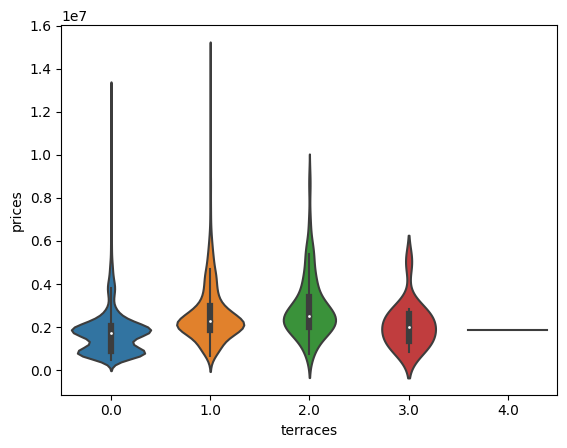

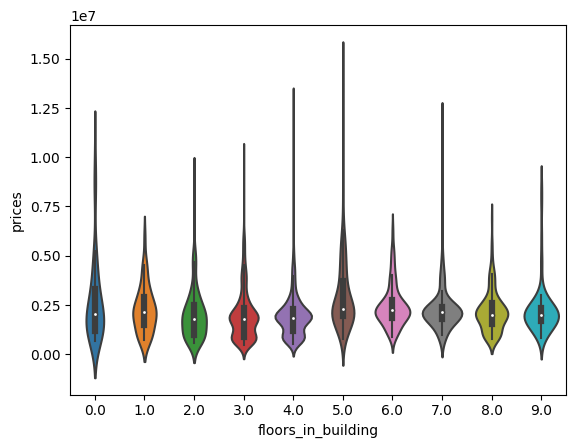

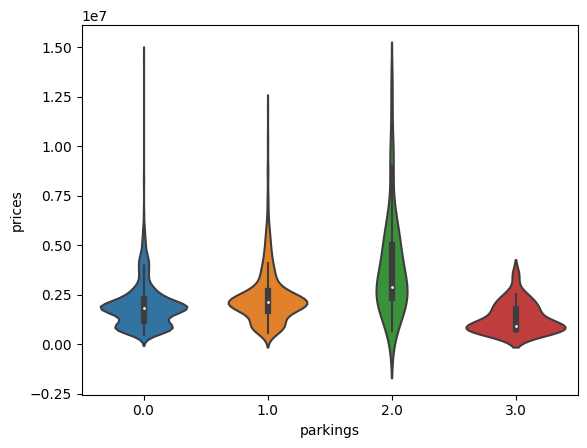

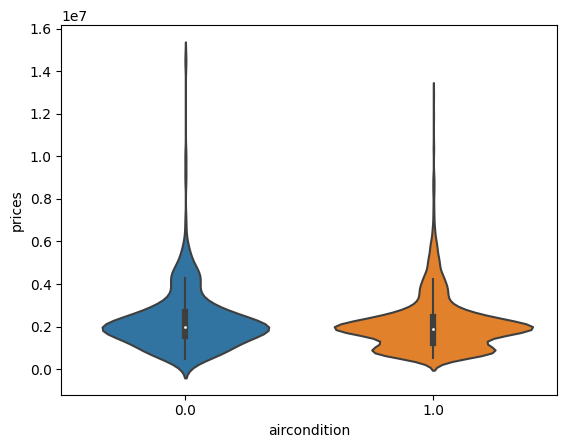

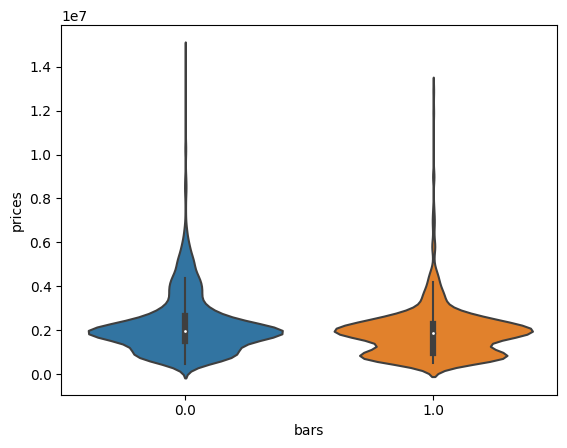

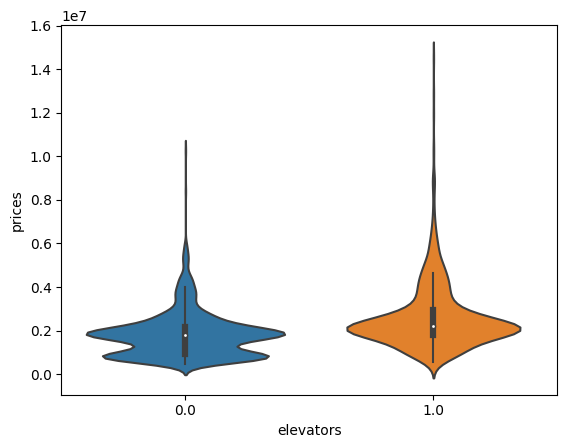

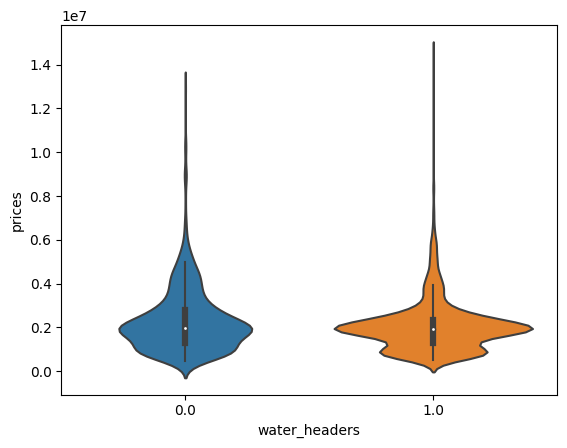

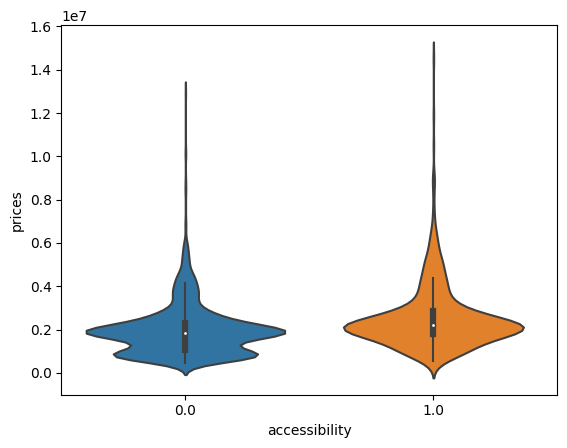

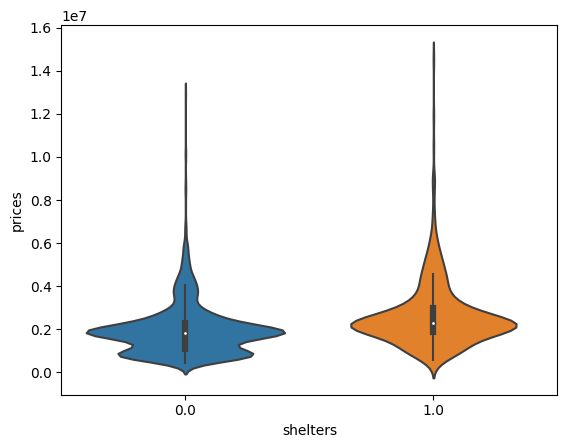

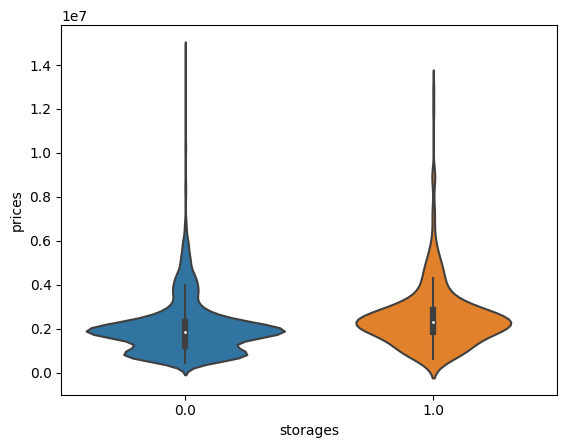

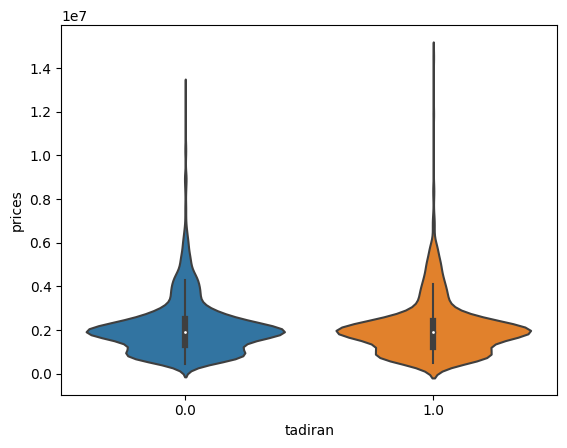

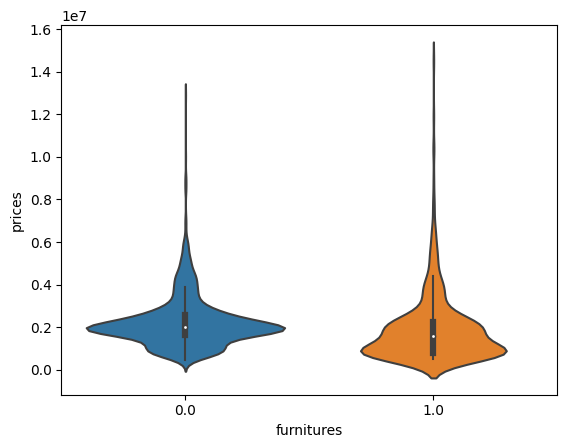

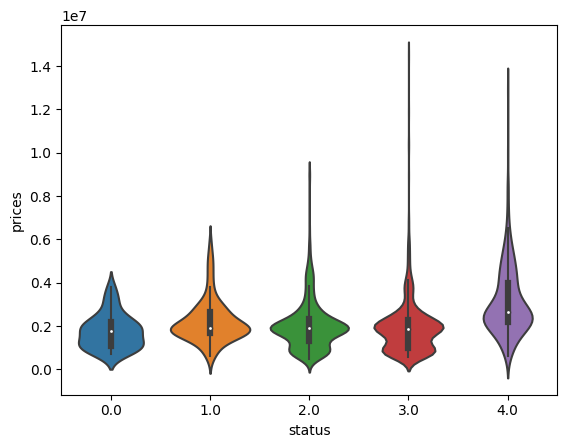

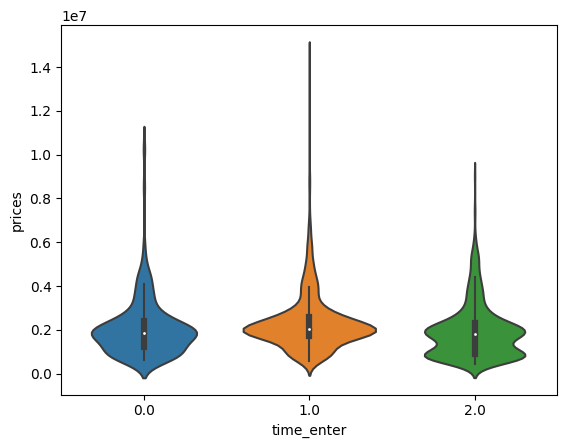

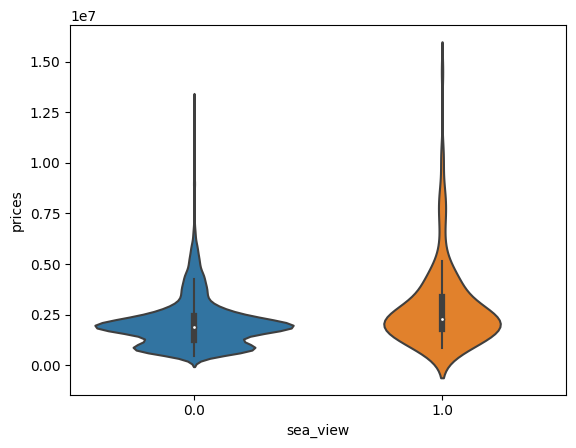

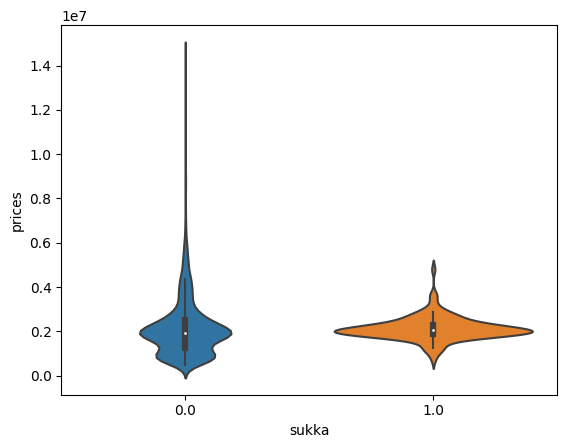

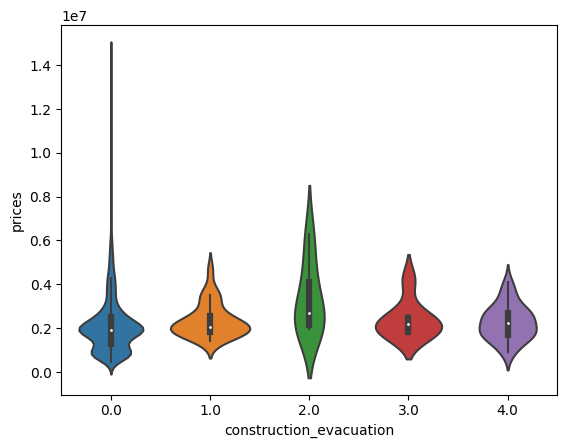

                           prices  terraces  floors_in_building  parkings   
prices                   1.000000  0.322099            0.050455  0.163231  \
terraces                 0.322099  1.000000            0.098368  0.203564   
floors_in_building       0.050455  0.098368            1.000000  0.217404   
parkings                 0.163231  0.203564            0.217404  1.000000   
aircondition            -0.042313 -0.022566            0.000091  0.072356   
bars                    -0.126445 -0.039293           -0.087732 -0.016962   
elevators                0.296973  0.266374            0.516451  0.412904   
water_headers           -0.094672  0.000905            0.032996  0.005431   
accessibility            0.197206  0.226559            0.374598  0.332928   
shelters                 0.228006  0.397438            0.281012  0.424519   
storages                 0.143425  0.238807            0.064997  0.231769   
tadiran                 -0.012197  0.043028            0.016868  0.059334   

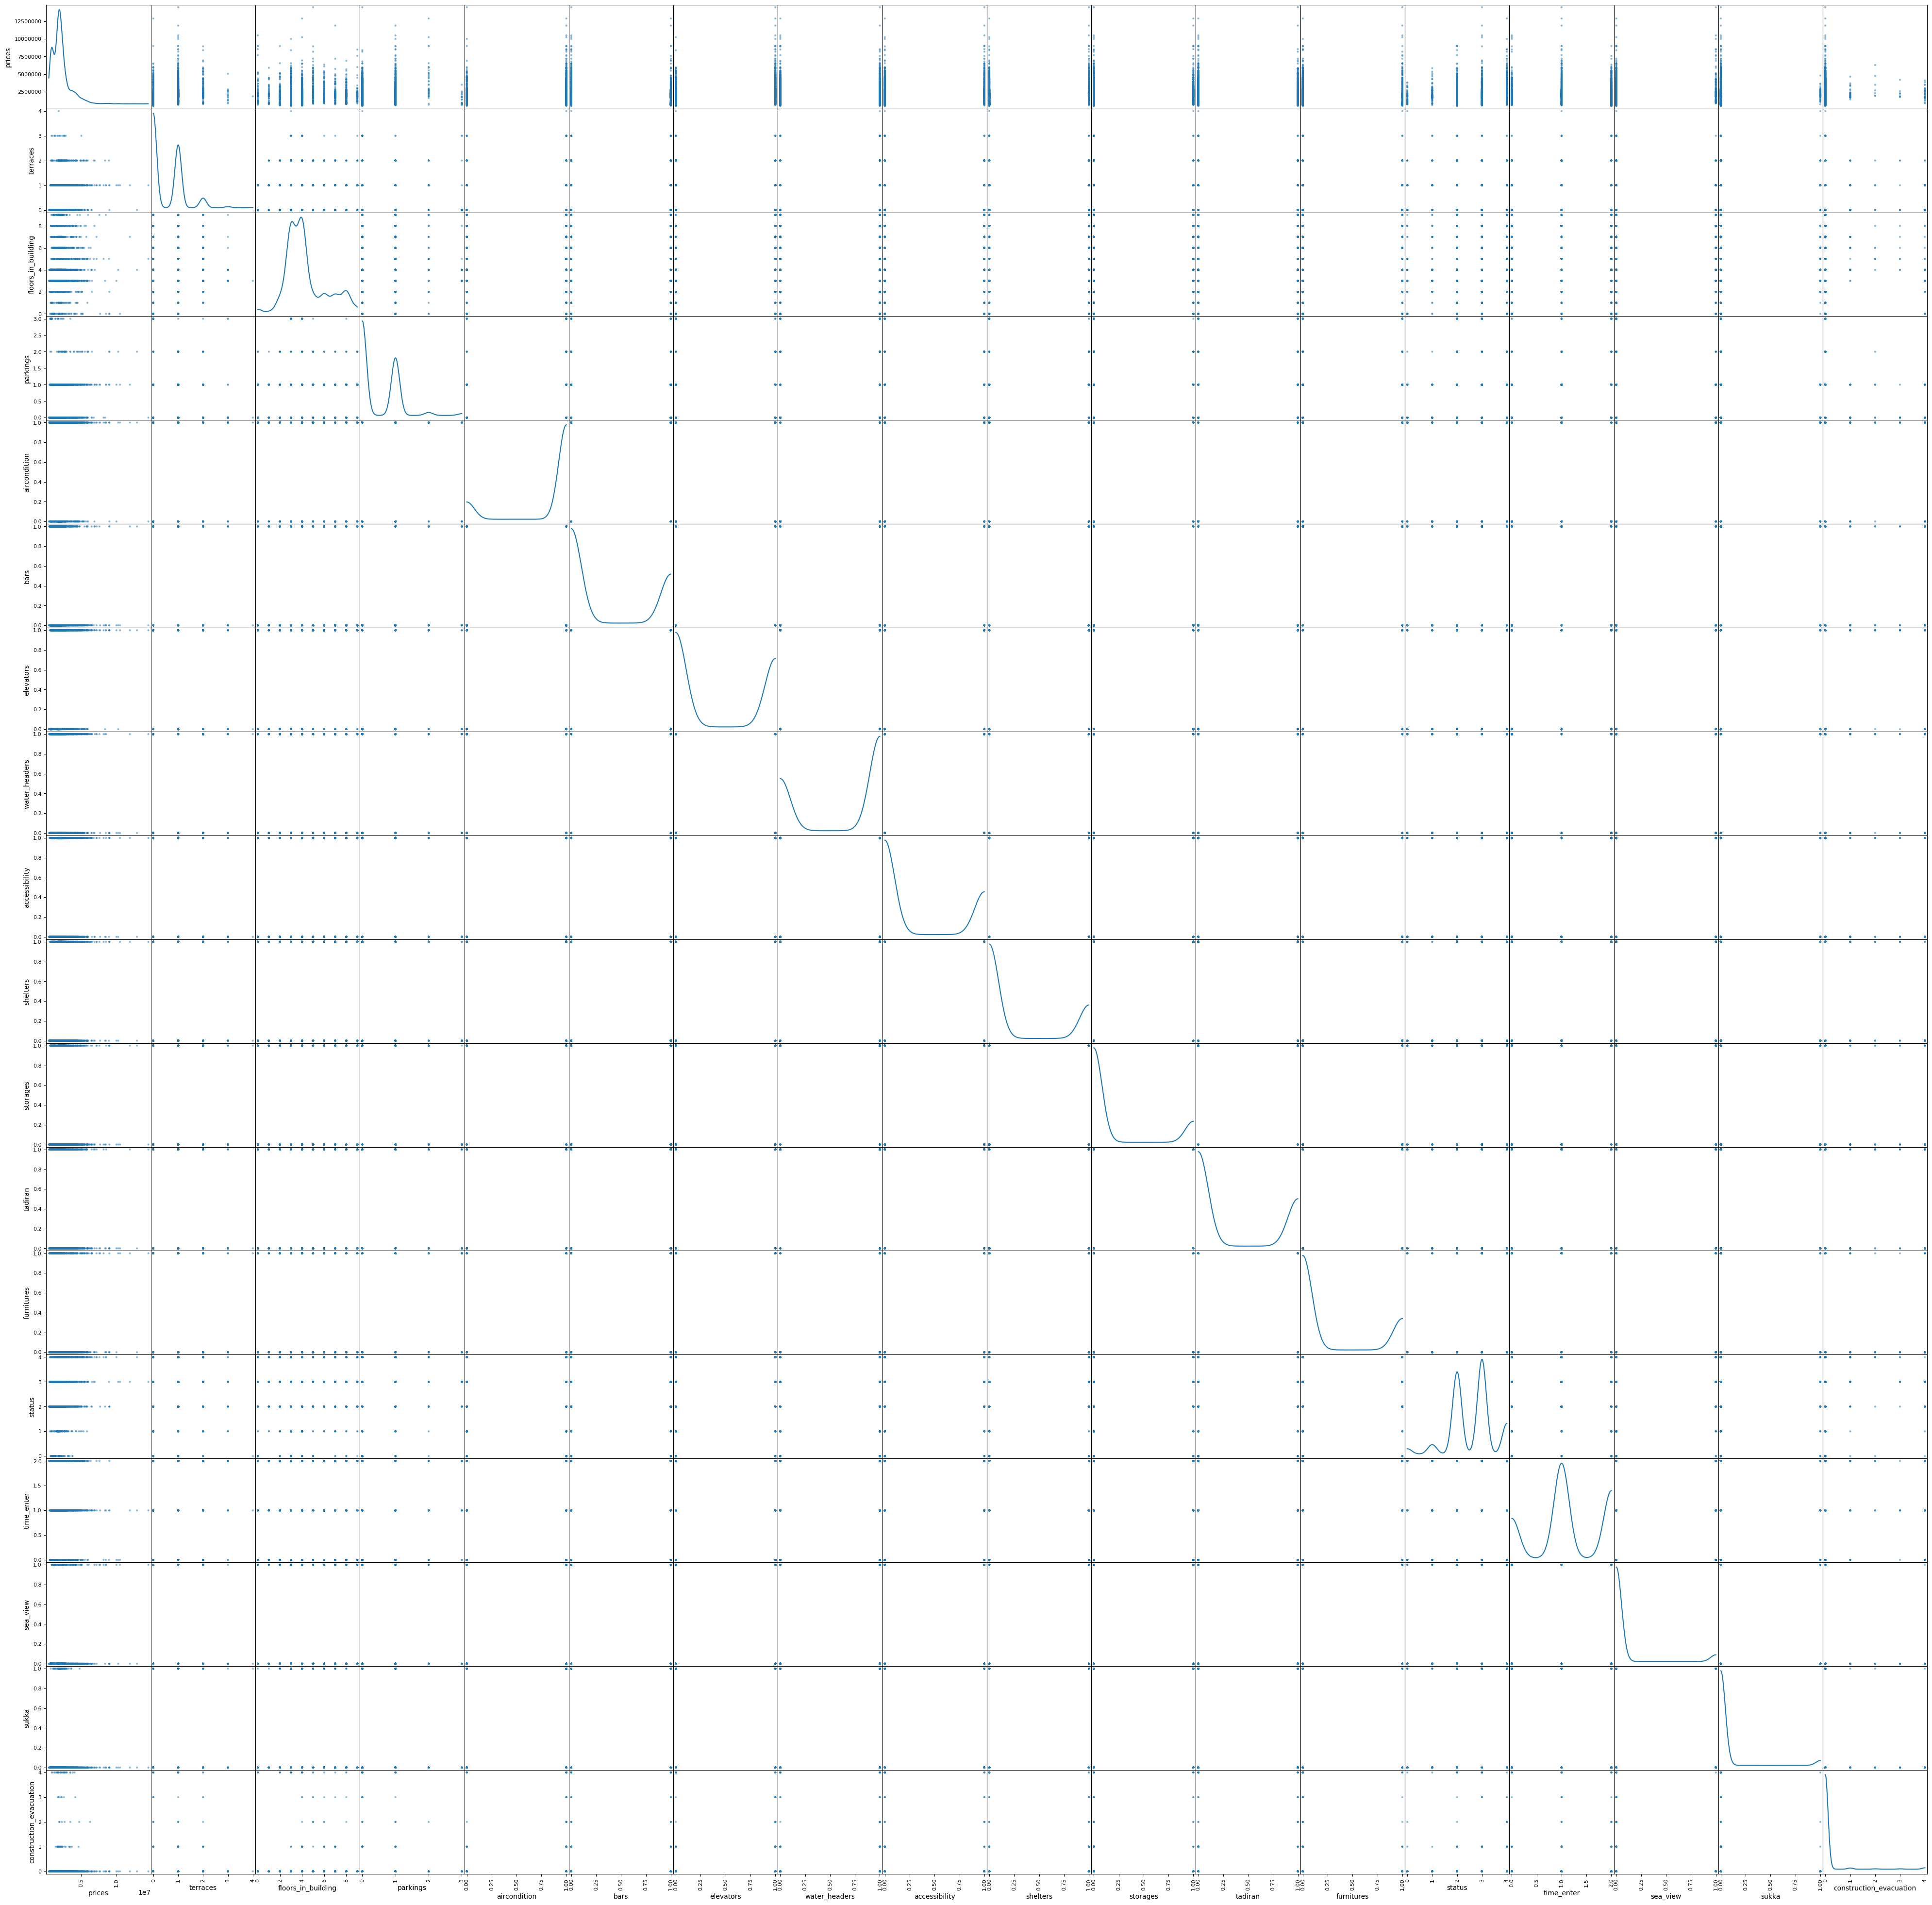

          prices      2010      2011      2012      2013      2014      2015   
prices  1.000000  0.647720  0.649862  0.664401  0.771898  0.749344  0.744478  \
2010    0.647720  1.000000  0.962589  0.926749  0.850377  0.754984  0.732457   
2011    0.649862  0.962589  1.000000  0.932849  0.866480  0.787383  0.743961   
2012    0.664401  0.926749  0.932849  1.000000  0.895160  0.791195  0.764736   
2013    0.771898  0.850377  0.866480  0.895160  1.000000  0.886530  0.856790   
2014    0.749344  0.754984  0.787383  0.791195  0.886530  1.000000  0.926118   
2015    0.744478  0.732457  0.743961  0.764736  0.856790  0.926118  1.000000   
2016    0.760701  0.715765  0.728381  0.751252  0.843227  0.902773  0.951507   
2017    0.768003  0.722393  0.723896  0.740449  0.840077  0.892302  0.934821   
2018    0.780111  0.719996  0.721461  0.747098  0.836847  0.884034  0.917865   
2019    0.766197  0.706696  0.706807  0.737810  0.829769  0.861617  0.890973   
2020    0.748014  0.613627  0.619893  0.

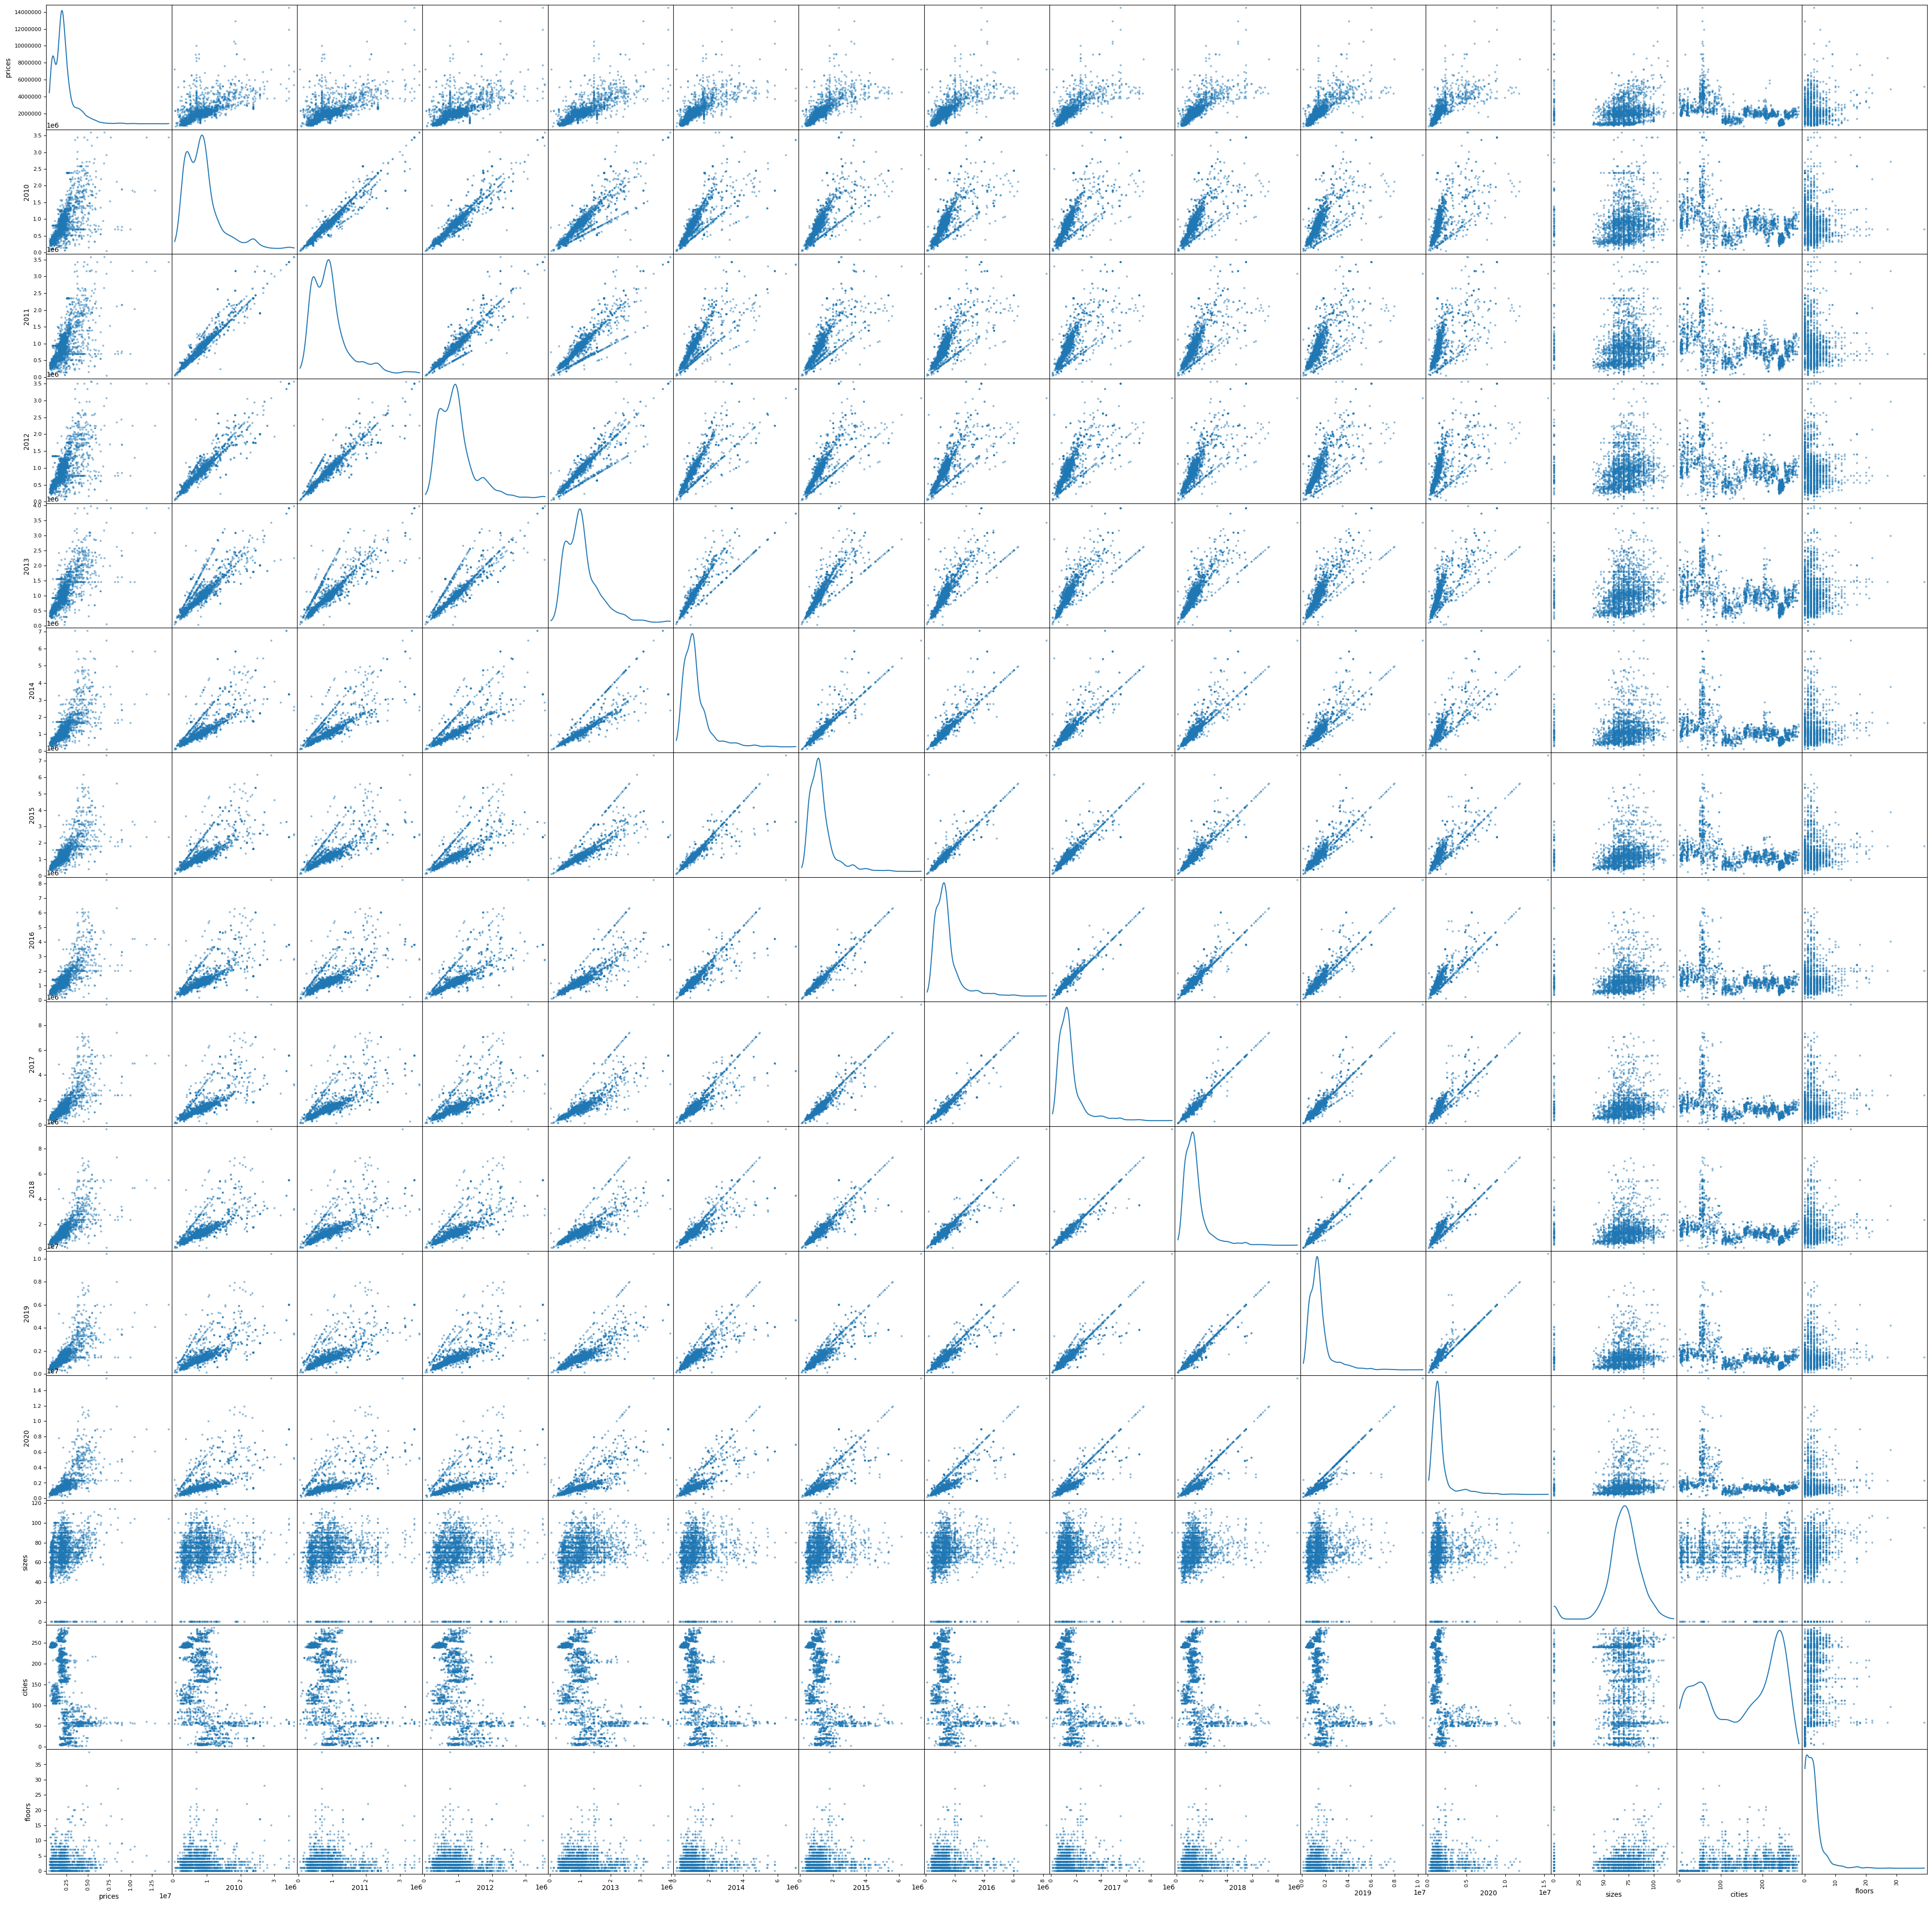

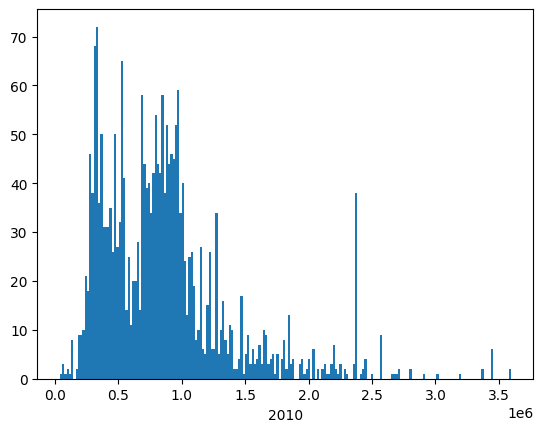

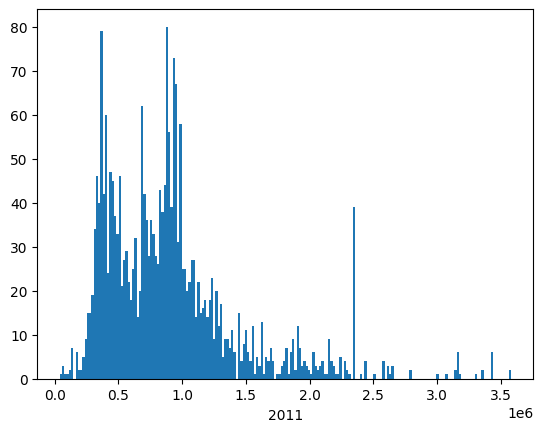

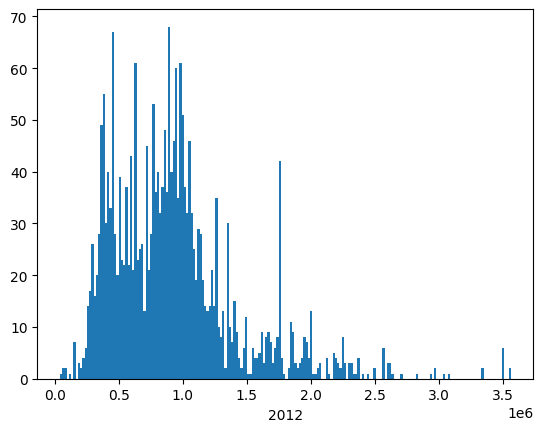

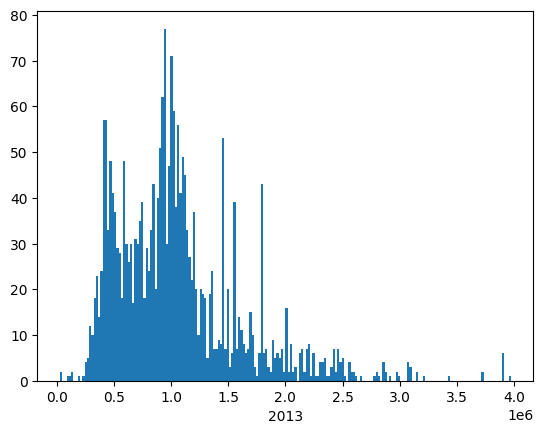

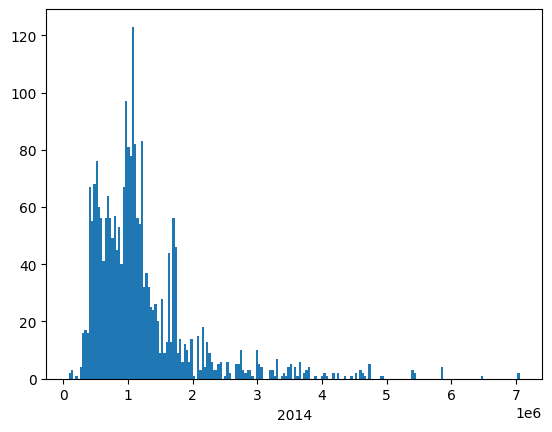

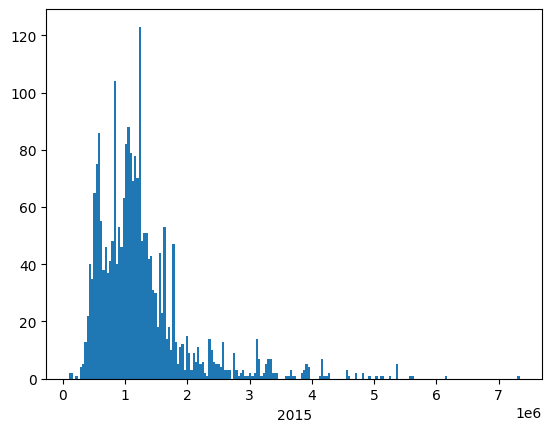

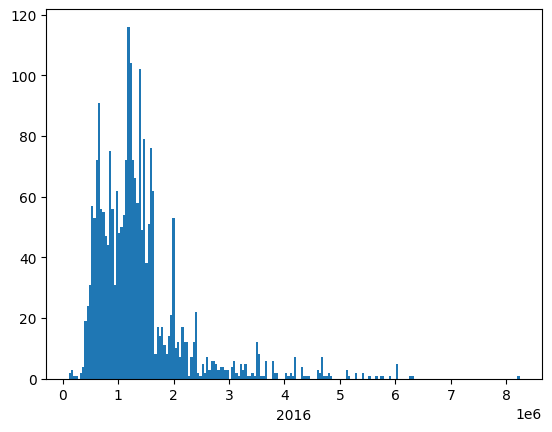

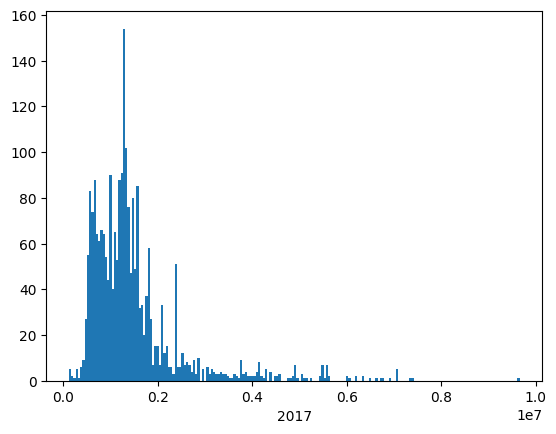

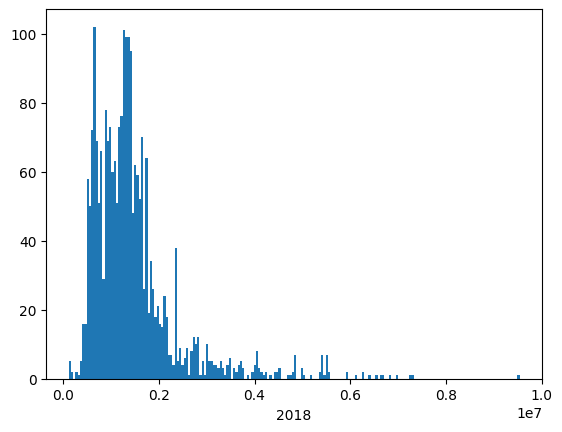

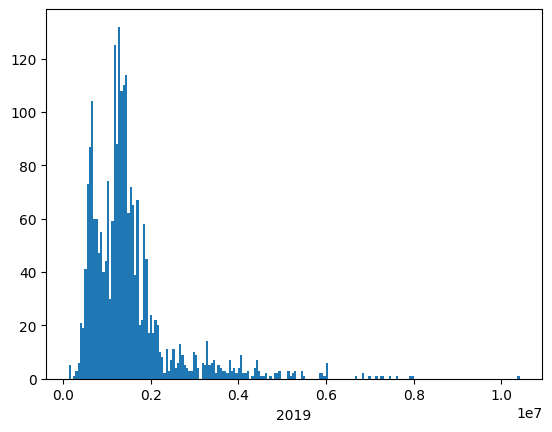

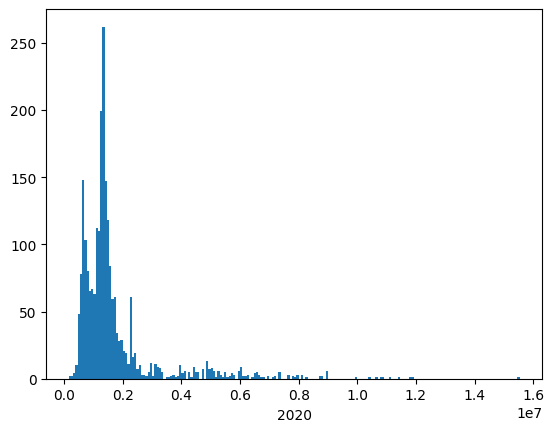

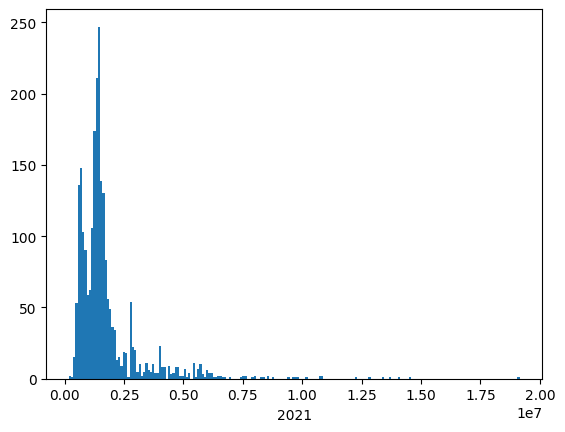

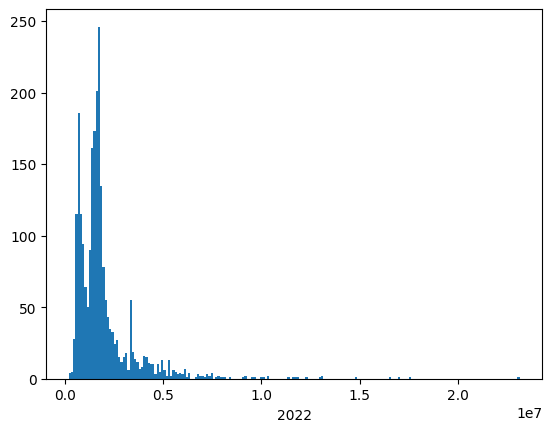

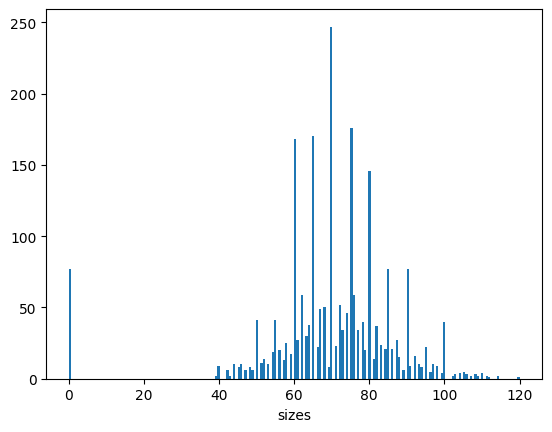

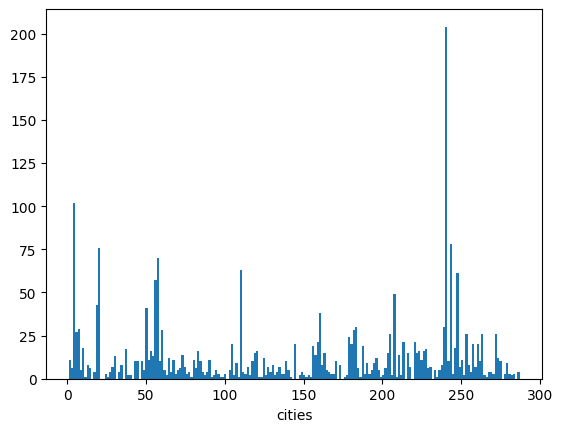

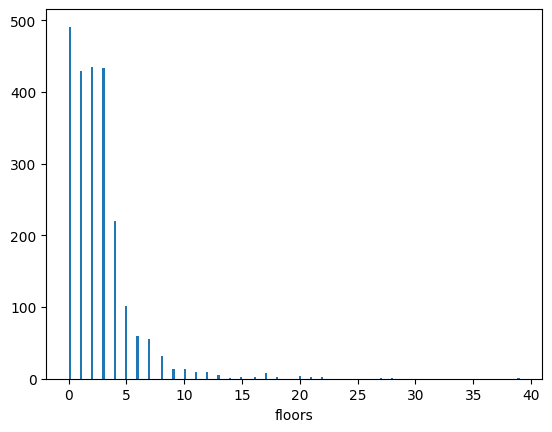

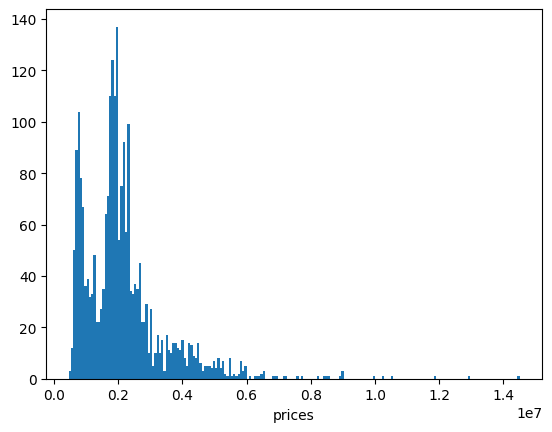

prices                     1.000000
terraces                   0.322099
floors_in_building         0.050455
parkings                   0.163231
aircondition              -0.042313
bars                      -0.126445
elevators                  0.296973
water_headers             -0.094672
accessibility              0.197206
shelters                   0.228006
storages                   0.143425
tadiran                   -0.012197
furnitures                -0.110193
status                     0.173436
time_enter                -0.067572
sea_view                   0.145078
sukka                     -0.003444
construction_evacuation    0.027396
Name: prices, dtype: float64
prices    1.000000
2010      0.647720
2011      0.649862
2012      0.664401
2013      0.771898
2014      0.749344
2015      0.744478
2016      0.760701
2017      0.768003
2018      0.780111
2019      0.766197
2020      0.748014
sizes     0.080574
cities   -0.523307
floors    0.114463
Name: prices, dtype: float64
['prices'

In [63]:
def my_main():
    cities = ['jerusalem', 'tel_aviv', 'haifa', 'rishon_lezion', 'petah_tikva', 'natanya', 'holon', 'beer_sheva', 'ashdod','bnei_brakh']
    # Define an empty DataFrame to store the combined data
    data = {'prices':[],'streets':[],'cities':[],'floors':[],'sizes':[],'terraces':[],
            'floors_in_building':[],'parkings':[],'aircondition':[],'bars':[],'elevators':[],'water_headers':[],
            'accessibility':[],'shelters':[],'storages':[],'tadiran':[],'furnitures':[],'status':[],
            'time_enter':[],'sea_view':[],'sukka':[],'construction_evacuation':[],
            '2010':[],'2011':[],'2012':[],'2013':[],'2014':[],'2015':[],'2016':[],
            '2017':[], '2018':[], '2019':[], '2020':[], '2021':[], '2022':[],'2023':[]
    }
    il_df = pd.DataFrame(data)
    max_neighborhood = 0 # Keep track of the maximum neighborhood value for reorganizing the cities column
    for city in cities:
        df= pd.read_csv(f"Data_handling\\dh_{city}_df_file_3_rooms.csv", encoding="hebrew")
        # Drop any 'Unnamed' columns
        for column in df.columns:
            if "Unnamed" in column:
                df.drop(column, axis=1, inplace=True)
        # Reorganize the cities column before concatenating to the DataFrame
        for row in range(0, df.shape[0]):
            df.loc[row, "cities"] = int(df.loc[row, "cities"]) + max_neighborhood
        max_neighborhood = df["cities"].max()
        # Concatenate the DataFrames
        il_df = pd.concat([il_df, df])
    # Write the new DataFrame to a new file
    il_df.to_csv("Data_handling\\dh_israel_df_file_3_rooms.csv", encoding="hebrew")
    # Print some information about the new DataFrame
    print(il_df.head())
    print(il_df.describe())
    print(il_df.info())
    # Perform exploratory data analysis
    plt_for_cor_prices("israel")
    plt_scatter_mat("israel")
    get_corr("israel")
    # Check for outliers in numeric columns
    columns_numeric = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020', '2021', '2022', 'sizes', 'cities', 'floors', 'prices']
    for col in columns_numeric:
        plt_for_outliers("israel", col)
     # Calculate and print evaluation results
    get_eval_res_1st("israel")
       
my_main() 